In [2]:
%matplotlib inline
from torch import optim, nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [3]:
class FeedForwardNet3(nn.Module):
    """ Simple feed forward network with three hidden layers."""
    def __init__(self): # initialize the model
        super(FeedForwardNet3, self).__init__() # call for the parent class to initialize
        # Nfeatures stands for the number of features that each galaxy
        # provides, e.g. its (g-r) color inside or outside the fiber,
        # magnitude in various bands, etc. 
        # Nfeatures should be adjusted if the number of galaxy features
        # changes. Otherwise FeedForwardNet3 will break.
        self.Nfeatures = 17
        
        # Noutcomes is the size of the output vector. Since we are
        # only calulate the SFR, Noutcomes is 1.
        self.Noutcomes = 1
        # Nsamples is the size of the packet of galaxies used in a single batch.
        self.Nsamples = 25
        weight1_shape = [self.Nfeatures, self.Nsamples]
        weight2_shape = [self.Nsamples, 1000]
        weight3_shape = [1000, 1000]
        weight4_shape = [1000, 1000]
        weight5_shape = [1000, 1000]
        weight6_shape = [1000, 1000]
        weight7_shape = [1000, self.Nsamples]
        weight8_shape = [self.Nsamples, self.Noutcomes]


        self.W1 = nn.Linear(*weight1_shape)
        self.W2 = nn.Linear(*weight2_shape)
        self.W3 = nn.Linear(*weight3_shape)
        self.W4 = nn.Linear(*weight4_shape)
        self.W5 = nn.Linear(*weight5_shape)
        self.W6 = nn.Linear(*weight6_shape)
        self.W7 = nn.Linear(*weight7_shape)
        self.W8 = nn.Linear(*weight8_shape)


    def forward(self, x):
        """
        this is the function that will be executed when we call the logistic regression on data.
        INPUT:
            x, a photometric data vector represented as a tensor of shape 27
        OUTPUT:
            forward_result, a tensor of shape 1
        """
        activation_fn = nn.LeakyReLU()

        forward_result = self.W1(x)
        forward_result = activation_fn(forward_result)

        forward_result = self.W2(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W3(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W4(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W5(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W6(forward_result)
        forward_result = activation_fn(forward_result)
        
        forward_result = self.W7(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W8(forward_result)

        forward_result = torch.reshape(forward_result, [self.Nsamples, self.Noutcomes])

        return forward_result

def train(model,loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model (instance of a neural network)
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    # num_epochs defines the number of times that the model repeats its training.
    # Higher num_epochs should lead to higher accuracy, but increasing computational 
    # complexity of training the model leads to increasing amount of time required 
    # for one training epoch. There is no rule for choosing num_epochs, aside from 
    # "go with your gut!". It's not unlike choosing the perfect grad school.
    num_epochs = 300
    
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            # run the model on the data
            Nsample = len(targets)
            Nfeatures = len(data.T)
            model_input = torch.reshape(data, (Nsample, Nfeatures))
            model_output = model(model_input)
            
            # Check for Nan and infinity numbers in the output, as NaN and inf
            # break the neural net when one feeds model_output to the loss function
            if torch.isnan(sum(sum(model_output))) or torch.isinf(sum(sum(model_output))):
                print("sum(sum(model_input))", sum(sum(model_input)))
                print("sum(sum(model_output))", sum(sum(model_output)))
                print('invalid input detected at iteration ', epoch)
            
            # Evaluate the quality of model_output by calculating the loss function
            loss = loss_fn(model_output, targets)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()
            
        print("loss", loss.item())
        # Give status reports every 50 epochs
        if epoch % 50==0:
            evaluate_train = np.round(evaluate(model,train_loader, Nsample=Nsample), 4)
            evaluate_test = np.round(evaluate(model,test_loader, Nsample=Nsample), 4)

            evaluate_test = np.round(evaluate_test, 4)
            dataseries = pd.Series({"epoch":int(epoch),
                                    "Train accuracy": evaluate_train,
                                    "Test accuracy": evaluate_test,
                                    "Loss" : np.round(loss.item(), 4)}
                                   )
            if epoch==0:
                df_accuracy = pd.DataFrame()

            df_accuracy = df_accuracy.append(dataseries, ignore_index=True)
            print(f" EPOCH {epoch}. Train accuracy: {evaluate_train}. Test accuracy: {evaluate_test}")





def evaluate(model, evaluation_set, loss_fn, Nsample=25, Nfeatures=17):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    correct = []
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        for data, targets in evaluation_set:
            try:
                model_input = torch.reshape(data, [Nsample, Nfeatures])
            except RuntimeError:
                break
            result = model(model_input)
            accuracy = loss_fn(model_output, targets)
    
    return accuracy

### Read in training data

In [46]:
sdss_photo_data = np.load("photometric_data.npy")
ground_truth_sfrs = np.load("sfr_data_synced_to_photo_dictionary.npy")

In [47]:
# Turn the input photometric data into a pandas DataFrame with the corresponding column names

photodf = pd.DataFrame(sdss_photo_data, columns=['fiber_g_mag', 'full_g_mag',
                                        'fiber_r_mag', 'full_r_mag',
                                        'fiber_z_mag', 'full_z_mag',
                                        'fiber_nuv_mag', 'full_nuv_mag',
                                        'fiber_fuv_mag', 'full_fuv_mag',
                                        'g_r_fiber', 'g_r_full',
                                        'r_z_fiber', 'r_z_full',
                                        'fuv_nuv_fiber', 'fuv_nuv_full', 'halpha_pos', 'halpha_neg'])

# Take and store a log value of H-alpha for optimal model training
photodf['halpha_pos'] = np.log10(photodf['halpha_pos'].values)
# Add the star formation rate column temporarily while we go through data cleaning
photodf['SFR'] = ground_truth_sfrs

# Take a look to make sure there are no surprises
photodf

/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,halpha_pos,halpha_neg,SFR
0,19.441998,20.630505,18.887556,20.072167,18.435331,19.592112,21.352145,22.856167,22.674904,24.027126,0.554442,1.742949,0.452225,0.480055,1.322760,1.170959,1.323939,0.0,-0.205
1,19.875634,20.527209,19.280281,19.929611,18.961168,19.625306,21.952400,22.795154,23.650975,24.351031,0.595353,1.246928,0.319113,0.304305,1.698575,1.555877,1.588927,0.0,-1.084
2,20.262839,20.262839,19.422085,19.422085,18.770072,18.770072,23.213055,23.213055,25.484405,25.484405,0.840754,0.840754,0.652013,0.652013,2.271350,2.271350,1.216455,0.0,-0.257
3,19.418698,20.525722,18.316665,19.407658,17.347735,18.345308,23.905483,25.205080,26.187729,26.671650,1.102034,2.209058,0.968930,1.062350,2.282246,1.466570,0.877957,0.0,-1.260
4,18.696263,19.643996,17.696755,18.630520,16.946103,17.745149,22.899712,24.311589,25.516199,26.510112,0.999507,1.947241,0.750653,0.885371,2.616488,2.198523,1.659765,0.0,0.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,18.928276,20.355564,17.998023,19.200435,17.378731,18.486148,23.963943,26.942791,26.960253,28.291149,0.930253,2.357541,0.619292,0.714287,2.996310,1.348358,-0.260124,0.0,-1.062
2171,18.884443,19.477370,18.040795,18.572602,17.376915,17.861229,21.513488,22.299300,23.010282,23.839867,0.843648,1.436575,0.663880,0.711374,1.496794,1.540568,1.319366,0.0,0.167
2172,18.518780,19.658515,17.943607,19.000971,17.553782,18.571518,20.079246,21.492285,21.536870,23.052125,0.575173,1.714908,0.389825,0.429454,1.457624,1.559841,1.425838,0.0,-0.170
2173,18.985073,19.653507,18.221637,18.837664,17.705806,18.294283,21.037060,21.883804,22.871531,23.746635,0.763435,1.431870,0.515831,0.543382,1.834472,1.862831,0.957478,0.0,-0.250


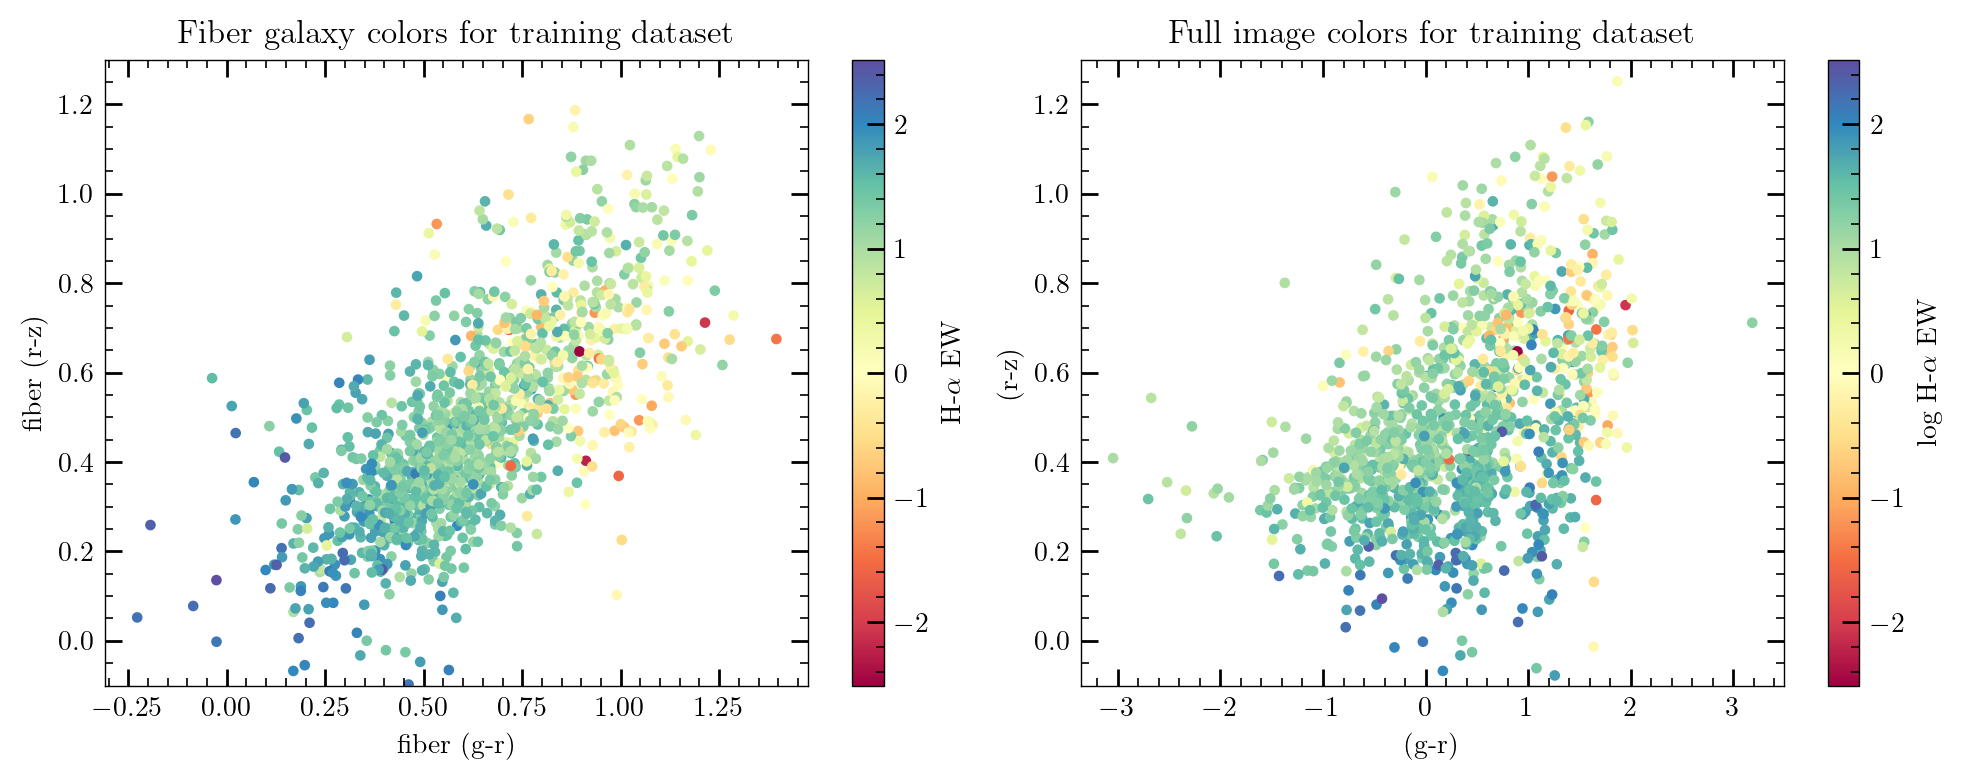

In [10]:
# We can make some diagnostic plots, for instance this pairing of color-color plots

fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(photodf['g_r_fiber'].values, photodf['r_z_fiber'].values, s=8,
                           c=photodf['halpha'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="fiber (g-r)", ylabel='fiber (r-z)', title="Fiber galaxy colors for training dataset", ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'H-$\alpha$ EW')

fiber_scat = axes[1].scatter(photodf['g_r_full'].values, photodf['r_z_full'].values,
                             c=photodf['halpha'].values, s=8,
                             cmap='Spectral')
cbar = fig.colorbar(fiber_scat, ax=axes[1])
axes[1].set(xlabel="(g-r)", ylabel='(r-z)', ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'log H-$\alpha$ EW')
axes[1].set_title("Full image colors for training dataset")
plt.tight_layout()

(array([  1.,   1.,   5.,  60., 812., 265.,  43.,  16.,  13.,  10.]),
 array([-2.84747585, -1.92640158, -1.0053273 , -0.08425303,  0.83682125,
         1.75789553,  2.6789698 ,  3.60004408,  4.52111835,  5.44219263,
         6.3632669 ]),
 <BarContainer object of 10 artists>)

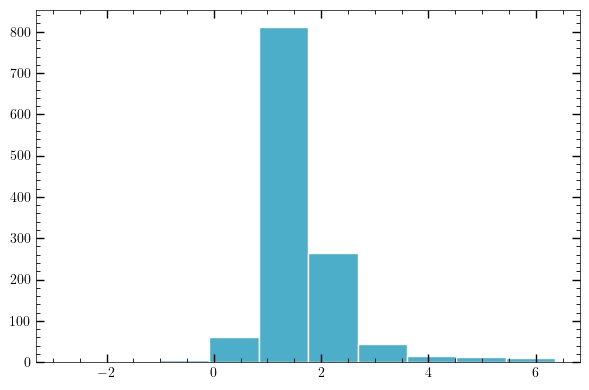

In [91]:
fig, axes = plt.subplots(dpi=100)
axes.hist(photodf['fuv_nuv_full'].values[photodf['fuv_nuv_full'].values<100])

In [99]:
print(len(most_uv))
print(len(photodf['fuv_nuv_full']))

1161
1350


Text(0.5, 1.0, 'Full image colors for training dataset')

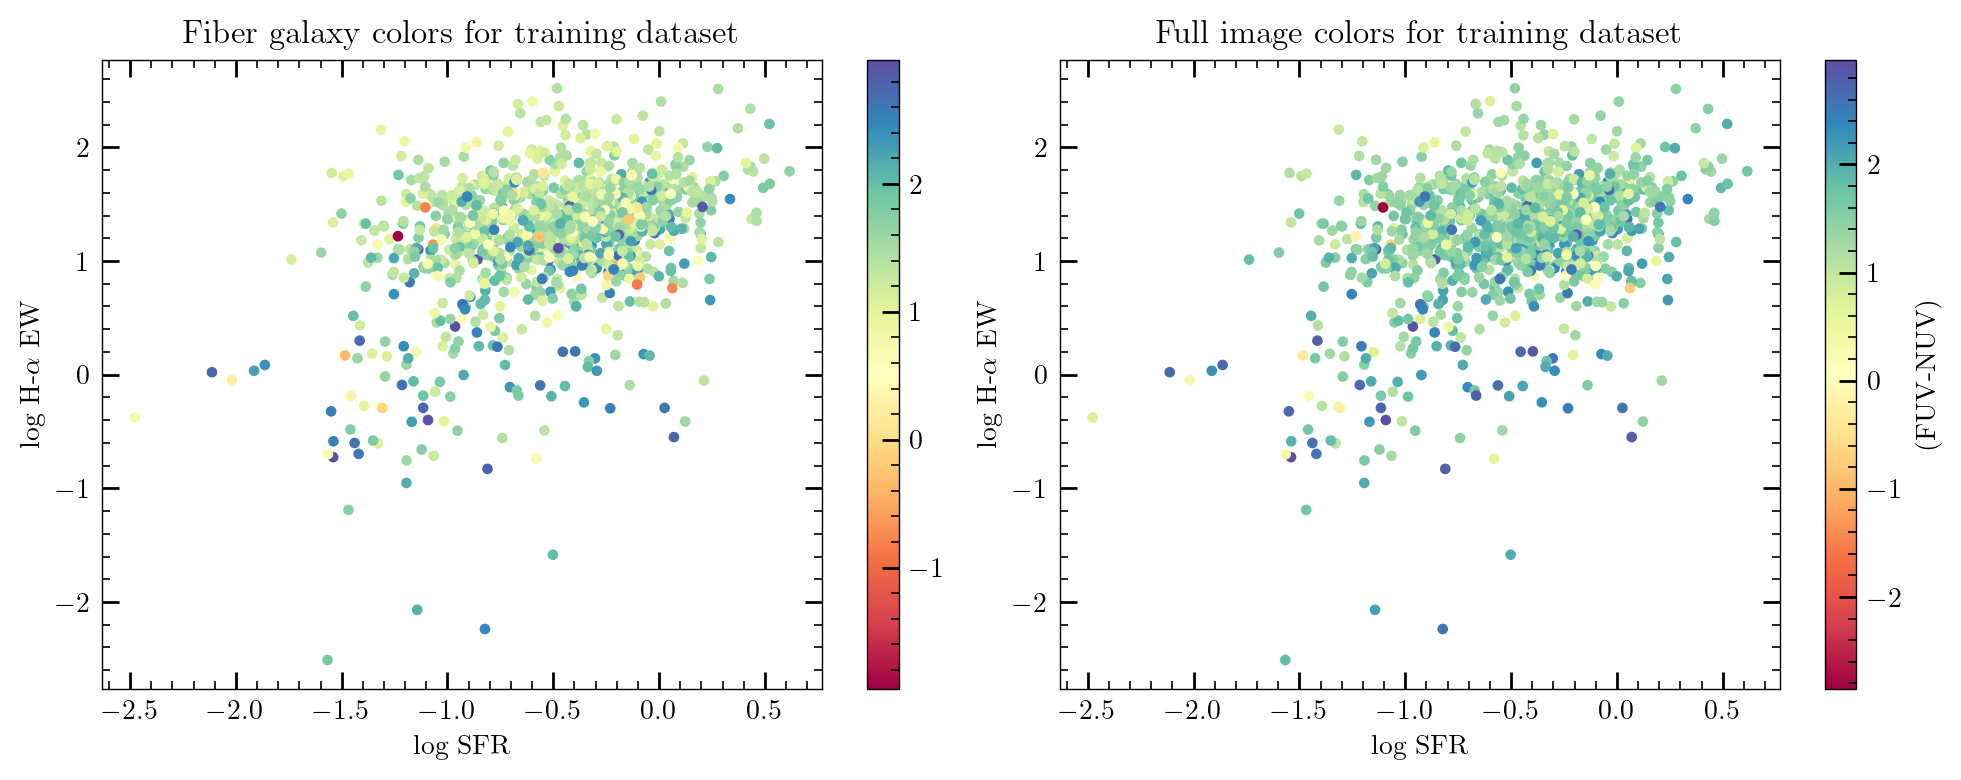

In [100]:
# We can make some diagnostic plots, for instance this pairing of color-color plots
most_uv = np.where((photodf['fuv_nuv_full'].values<3) & (photodf['fuv_nuv_fiber'].values<3))[0]
fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(photodf['SFR'].values[most_uv], photodf['halpha'].values[most_uv], s=8,
                           c=photodf['fuv_nuv_fiber'].values[most_uv],
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'log H-$\alpha$ EW', title="Fiber galaxy colors for training dataset", 
            )
cbar.ax.set_ylabel(r'')

fiber_scat = axes[1].scatter(photodf['SFR'].values[most_uv], photodf['halpha'].values[most_uv], s=8,
                             c=photodf['fuv_nuv_full'].values[most_uv],
                             cmap='Spectral')
cbar = fig.colorbar(fiber_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'log H-$\alpha$ EW',)
cbar.ax.set_ylabel(r'(FUV-NUV)')
axes[1].set_title("Full image colors for training dataset")


## Clean training data

In [51]:
for colname in cleaned_photodf.columns:
    print(colname)
    print(max(cleaned_photodf[colname].values))
    
    print(min(cleaned_photodf[colname].values))

fiber_g_mag
20.715729246381436
16.405638830585573
full_g_mag
22.297607346133972
15.902766332783276
fiber_r_mag
20.155496257997164
15.501616740662833
full_r_mag
21.464031415707005
15.034435604396403
fiber_z_mag
19.931611903032316
14.841081531568758
full_z_mag
21.11066711192823
14.387168028940398
fiber_nuv_mag
26.628265743803546
18.82592497884071
full_nuv_mag
28.660302530282664
18.292526240053558
fiber_fuv_mag
28.593715673422615
20.02629180605266
full_fuv_mag
32.62741285417215
19.825434760973906
g_r_fiber
1.4894293679033268
-0.14599189366997578
g_r_full
4.231547418370237
-1.710363486121139
r_z_fiber
1.3047441461410827
-0.5469302250669692
r_z_full
1.534087931082457
-1.2308909015491203
fuv_nuv_fiber
6.014176310975984
-1.755827407079856
fuv_nuv_full
6.948217588714957
-2.8474758519839156
halpha_pos
2.698673260551478
-3.1926264827655486
halpha_neg
0.0
0.0


In [49]:
# Replace instances of infinity in the DataFrame with Nan, and then drop any rows
# that contain NaN entries:
cleaned_photodf = photodf.replace([np.inf, -np.inf, 1000], np.nan).dropna(axis=0)
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,halpha_pos,halpha_neg,SFR
0,19.441998,20.630505,18.887556,20.072167,18.435331,19.592112,21.352145,22.856167,22.674904,24.027126,0.554442,1.742949,0.452225,0.480055,1.322760,1.170959,1.323939,0.0,-0.205
1,19.875634,20.527209,19.280281,19.929611,18.961168,19.625306,21.952400,22.795154,23.650975,24.351031,0.595353,1.246928,0.319113,0.304305,1.698575,1.555877,1.588927,0.0,-1.084
2,20.262839,20.262839,19.422085,19.422085,18.770072,18.770072,23.213055,23.213055,25.484405,25.484405,0.840754,0.840754,0.652013,0.652013,2.271350,2.271350,1.216455,0.0,-0.257
3,19.418698,20.525722,18.316665,19.407658,17.347735,18.345308,23.905483,25.205080,26.187729,26.671650,1.102034,2.209058,0.968930,1.062350,2.282246,1.466570,0.877957,0.0,-1.260
4,18.696263,19.643996,17.696755,18.630520,16.946103,17.745149,22.899712,24.311589,25.516199,26.510112,0.999507,1.947241,0.750653,0.885371,2.616488,2.198523,1.659765,0.0,0.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,18.928276,20.355564,17.998023,19.200435,17.378731,18.486148,23.963943,26.942791,26.960253,28.291149,0.930253,2.357541,0.619292,0.714287,2.996310,1.348358,-0.260124,0.0,-1.062
2171,18.884443,19.477370,18.040795,18.572602,17.376915,17.861229,21.513488,22.299300,23.010282,23.839867,0.843648,1.436575,0.663880,0.711374,1.496794,1.540568,1.319366,0.0,0.167
2172,18.518780,19.658515,17.943607,19.000971,17.553782,18.571518,20.079246,21.492285,21.536870,23.052125,0.575173,1.714908,0.389825,0.429454,1.457624,1.559841,1.425838,0.0,-0.170
2173,18.985073,19.653507,18.221637,18.837664,17.705806,18.294283,21.037060,21.883804,22.871531,23.746635,0.763435,1.431870,0.515831,0.543382,1.834472,1.862831,0.957478,0.0,-0.250


In [50]:
# Now extract the SFR column back out
cleaned_SFR = cleaned_photodf['SFR'].values
cleaned_photodf = cleaned_photodf.drop(columns=['SFR'])
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,halpha_pos,halpha_neg
0,19.441998,20.630505,18.887556,20.072167,18.435331,19.592112,21.352145,22.856167,22.674904,24.027126,0.554442,1.742949,0.452225,0.480055,1.322760,1.170959,1.323939,0.0
1,19.875634,20.527209,19.280281,19.929611,18.961168,19.625306,21.952400,22.795154,23.650975,24.351031,0.595353,1.246928,0.319113,0.304305,1.698575,1.555877,1.588927,0.0
2,20.262839,20.262839,19.422085,19.422085,18.770072,18.770072,23.213055,23.213055,25.484405,25.484405,0.840754,0.840754,0.652013,0.652013,2.271350,2.271350,1.216455,0.0
3,19.418698,20.525722,18.316665,19.407658,17.347735,18.345308,23.905483,25.205080,26.187729,26.671650,1.102034,2.209058,0.968930,1.062350,2.282246,1.466570,0.877957,0.0
4,18.696263,19.643996,17.696755,18.630520,16.946103,17.745149,22.899712,24.311589,25.516199,26.510112,0.999507,1.947241,0.750653,0.885371,2.616488,2.198523,1.659765,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,18.928276,20.355564,17.998023,19.200435,17.378731,18.486148,23.963943,26.942791,26.960253,28.291149,0.930253,2.357541,0.619292,0.714287,2.996310,1.348358,-0.260124,0.0
2171,18.884443,19.477370,18.040795,18.572602,17.376915,17.861229,21.513488,22.299300,23.010282,23.839867,0.843648,1.436575,0.663880,0.711374,1.496794,1.540568,1.319366,0.0
2172,18.518780,19.658515,17.943607,19.000971,17.553782,18.571518,20.079246,21.492285,21.536870,23.052125,0.575173,1.714908,0.389825,0.429454,1.457624,1.559841,1.425838,0.0
2173,18.985073,19.653507,18.221637,18.837664,17.705806,18.294283,21.037060,21.883804,22.871531,23.746635,0.763435,1.431870,0.515831,0.543382,1.834472,1.862831,0.957478,0.0


## Train

In [32]:
# Calculate the size of the training/testing split of the data
data_length = len(cleaned_photodf_nohalpha)
train_cap = int(np.floor(0.80*data_length / 50)*50)
print(train_cap)

#------Normalize the data columns------
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = MinMaxScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

750
number of epochs 2000
epoch 0
loss 0.5068249702453613
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.0. Test accuracy: 0.0
epoch 1
loss 0.44890663027763367
epoch 2
loss 0.39860206842422485
epoch 3
loss 0.3548789322376251
epoch 4
loss 0.3167724311351776
epoch 5
loss 0.28318512439727783
 EPOCH 5. Progress: 0.25%. 
 Train accuracy: 0.0. Test accuracy: 0.008
epoch 6
loss 0.2534113824367523
epoch 7
loss 0.2269144505262375
epoch 8
loss 0.2032938450574875
epoch 9
loss 0.182192862033844
epoch 10
loss 0.16331630945205688
 EPOCH 10. Progress: 0.5%. 
 Train accuracy: 0.0147. Test accuracy: 0.008
epoch 11
loss 0.14644628763198853
epoch 12
loss 0.1313932090997696
epoch 13
loss 0.11798630654811859
epoch 14
loss 0.10607843101024628
epoch 15
loss 0.0955338105559349
 EPOCH 15. Progress: 0.75%. 
 Train accuracy: 0.0587. Test accuracy: 0.06
epoch 16
loss 0.08622836321592331
epoch 17
loss 0.07803525030612946
epoch 18
loss 0.07084593176841736
epoch 19
loss 0.0645512044429779
epoch 20
loss 0.059035595506

 EPOCH 165. Progress: 8.25%. 
 Train accuracy: 0.264. Test accuracy: 0.248
epoch 166
loss 0.021270835772156715
epoch 167
loss 0.021267881616950035
epoch 168
loss 0.02126493491232395
epoch 169
loss 0.021262014284729958
epoch 170
loss 0.02125910110771656
 EPOCH 170. Progress: 8.5%. 
 Train accuracy: 0.264. Test accuracy: 0.248
epoch 171
loss 0.021256182342767715
epoch 172
loss 0.021253246814012527
epoch 173
loss 0.021250316873192787
epoch 174
loss 0.021247468888759613
epoch 175
loss 0.02124463953077793
 EPOCH 175. Progress: 8.75%. 
 Train accuracy: 0.2613. Test accuracy: 0.248
epoch 176
loss 0.021241821348667145
epoch 177
loss 0.021239032968878746
epoch 178
loss 0.021236196160316467
epoch 179
loss 0.021233370527625084
epoch 180
loss 0.021230584010481834
 EPOCH 180. Progress: 9.0%. 
 Train accuracy: 0.2613. Test accuracy: 0.248
epoch 181
loss 0.021227777004241943
epoch 182
loss 0.021224969998002052
epoch 183
loss 0.021222136914730072
epoch 184
loss 0.021219298243522644
epoch 185
loss 0.02

 EPOCH 330. Progress: 16.5%. 
 Train accuracy: 0.2627. Test accuracy: 0.256
epoch 331
loss 0.020864620804786682
epoch 332
loss 0.020862281322479248
epoch 333
loss 0.020859939977526665
epoch 334
loss 0.020857607945799828
epoch 335
loss 0.020855281502008438
 EPOCH 335. Progress: 16.75%. 
 Train accuracy: 0.2627. Test accuracy: 0.256
epoch 336
loss 0.020852956920862198
epoch 337
loss 0.020850639790296555
epoch 338
loss 0.02084832638502121
epoch 339
loss 0.02084602415561676
epoch 340
loss 0.02084370329976082
 EPOCH 340. Progress: 17.0%. 
 Train accuracy: 0.2627. Test accuracy: 0.256
epoch 341
loss 0.020841386169195175
epoch 342
loss 0.020839083939790726
epoch 343
loss 0.02083679288625717
epoch 344
loss 0.02083451673388481
epoch 345
loss 0.02083221822977066
 EPOCH 345. Progress: 17.25%. 
 Train accuracy: 0.264. Test accuracy: 0.256
epoch 346
loss 0.020829925313591957
epoch 347
loss 0.020827623084187508
epoch 348
loss 0.020825326442718506
epoch 349
loss 0.020823029801249504
epoch 350
loss 0.

loss 0.020480703562498093
epoch 494
loss 0.020478272810578346
epoch 495
loss 0.020475853234529495
 EPOCH 495. Progress: 24.75%. 
 Train accuracy: 0.2613. Test accuracy: 0.256
epoch 496
loss 0.020473429933190346
epoch 497
loss 0.020471002906560898
epoch 498
loss 0.020468570291996002
epoch 499
loss 0.020466189831495285
epoch 500
loss 0.020463816821575165
 EPOCH 500. Progress: 25.0%. 
 Train accuracy: 0.2613. Test accuracy: 0.256
epoch 501
loss 0.020461421459913254
epoch 502
loss 0.020459018647670746
epoch 503
loss 0.020456619560718536
epoch 504
loss 0.020454220473766327
epoch 505
loss 0.02045181207358837
 EPOCH 505. Progress: 25.25%. 
 Train accuracy: 0.2613. Test accuracy: 0.256
epoch 506
loss 0.02044939249753952
epoch 507
loss 0.020446978509426117
epoch 508
loss 0.020444564521312714
epoch 509
loss 0.020442161709070206
epoch 510
loss 0.02043975330889225
 EPOCH 510. Progress: 25.5%. 
 Train accuracy: 0.2613. Test accuracy: 0.256
epoch 511
loss 0.020437370985746384
epoch 512
loss 0.020434

loss 0.020112846046686172
 EPOCH 655. Progress: 32.75%. 
 Train accuracy: 0.264. Test accuracy: 0.244
epoch 656
loss 0.020110750570893288
epoch 657
loss 0.020108649507164955
epoch 658
loss 0.020106539130210876
epoch 659
loss 0.02010442689061165
epoch 660
loss 0.02010231465101242
 EPOCH 660. Progress: 33.0%. 
 Train accuracy: 0.264. Test accuracy: 0.244
epoch 661
loss 0.020100204274058342
epoch 662
loss 0.02009812742471695
epoch 663
loss 0.02009608782827854
epoch 664
loss 0.020094046369194984
epoch 665
loss 0.020092008635401726
 EPOCH 665. Progress: 33.25%. 
 Train accuracy: 0.264. Test accuracy: 0.244
epoch 666
loss 0.020090000703930855
epoch 667
loss 0.02008797973394394
epoch 668
loss 0.020085958763957024
epoch 669
loss 0.020083941519260406
epoch 670
loss 0.020081927999854088
 EPOCH 670. Progress: 33.5%. 
 Train accuracy: 0.264. Test accuracy: 0.244
epoch 671
loss 0.02007991634309292
epoch 672
loss 0.020077895373106003
epoch 673
loss 0.020075876265764236
epoch 674
loss 0.0200738646090

loss 0.019779140129685402
epoch 820
loss 0.019777121022343636
 EPOCH 820. Progress: 41.0%. 
 Train accuracy: 0.26. Test accuracy: 0.24
epoch 821
loss 0.019775094464421272
epoch 822
loss 0.01977301947772503
epoch 823
loss 0.019770946353673935
epoch 824
loss 0.019768841564655304
epoch 825
loss 0.01976676844060421
 EPOCH 825. Progress: 41.25%. 
 Train accuracy: 0.26. Test accuracy: 0.24
epoch 826
loss 0.019764699041843414
epoch 827
loss 0.01976259984076023
epoch 828
loss 0.019760511815547943
epoch 829
loss 0.019758397713303566
epoch 830
loss 0.019756309688091278
 EPOCH 830. Progress: 41.5%. 
 Train accuracy: 0.26. Test accuracy: 0.24
epoch 831
loss 0.019754216074943542
epoch 832
loss 0.019752103835344315
epoch 833
loss 0.01975000835955143
epoch 834
loss 0.01974792219698429
epoch 835
loss 0.019745798781514168
 EPOCH 835. Progress: 41.75%. 
 Train accuracy: 0.2613. Test accuracy: 0.24
epoch 836
loss 0.01974366419017315
epoch 837
loss 0.019741542637348175
epoch 838
loss 0.01973947323858738
e

loss 0.019452031701803207
epoch 982
loss 0.019450219348073006
epoch 983
loss 0.0194484144449234
epoch 984
loss 0.019446609541773796
epoch 985
loss 0.01944480463862419
 EPOCH 985. Progress: 49.25%. 
 Train accuracy: 0.2613. Test accuracy: 0.248
epoch 986
loss 0.01944301463663578
epoch 987
loss 0.019441261887550354
epoch 988
loss 0.019439511001110077
epoch 989
loss 0.019437767565250397
epoch 990
loss 0.01943603903055191
 EPOCH 990. Progress: 49.5%. 
 Train accuracy: 0.2613. Test accuracy: 0.248
epoch 991
loss 0.019434314221143723
epoch 992
loss 0.019432587549090385
epoch 993
loss 0.01943086087703705
epoch 994
loss 0.019429145380854607
epoch 995
loss 0.019427426159381866
 EPOCH 995. Progress: 49.75%. 
 Train accuracy: 0.2613. Test accuracy: 0.248
epoch 996
loss 0.019425712525844574
epoch 997
loss 0.019424010068178177
epoch 998
loss 0.019422322511672974
epoch 999
loss 0.019420631229877472
epoch 1000
loss 0.01941893994808197
 EPOCH 1000. Progress: 50.0%. 
 Train accuracy: 0.2613. Test accur

loss 0.019178247079253197
epoch 1144
loss 0.01917661353945732
epoch 1145
loss 0.019174974411725998
 EPOCH 1145. Progress: 57.25%. 
 Train accuracy: 0.26. Test accuracy: 0.248
epoch 1146
loss 0.019173337146639824
epoch 1147
loss 0.0191716980189085
epoch 1148
loss 0.019170060753822327
epoch 1149
loss 0.019168421626091003
epoch 1150
loss 0.019166793674230576
 EPOCH 1150. Progress: 57.49999999999999%. 
 Train accuracy: 0.26. Test accuracy: 0.248
epoch 1151
loss 0.0191651564091444
epoch 1152
loss 0.01916351355612278
epoch 1153
loss 0.019161872565746307
epoch 1154
loss 0.019160229712724686
epoch 1155
loss 0.019158590584993362
 EPOCH 1155. Progress: 57.75%. 
 Train accuracy: 0.26. Test accuracy: 0.248
epoch 1156
loss 0.01915694773197174
epoch 1157
loss 0.01915530301630497
epoch 1158
loss 0.01915367692708969
epoch 1159
loss 0.019152041524648666
epoch 1160
loss 0.019150443375110626
 EPOCH 1160. Progress: 57.99999999999999%. 
 Train accuracy: 0.26. Test accuracy: 0.248
epoch 1161
loss 0.01914884

 EPOCH 1300. Progress: 65.0%. 
 Train accuracy: 0.2627. Test accuracy: 0.248
epoch 1301
loss 0.018925847485661507
epoch 1302
loss 0.01892431639134884
epoch 1303
loss 0.018922781571745872
epoch 1304
loss 0.018921248614788055
epoch 1305
loss 0.01891971379518509
 EPOCH 1305. Progress: 65.25%. 
 Train accuracy: 0.2627. Test accuracy: 0.248
epoch 1306
loss 0.018918178975582123
epoch 1307
loss 0.018916640430688858
epoch 1308
loss 0.01891510561108589
epoch 1309
loss 0.018913572654128075
epoch 1310
loss 0.01891203410923481
 EPOCH 1310. Progress: 65.5%. 
 Train accuracy: 0.2627. Test accuracy: 0.248
epoch 1311
loss 0.018910499289631844
epoch 1312
loss 0.018908968195319176
epoch 1313
loss 0.01890743337571621
epoch 1314
loss 0.01890590973198414
epoch 1315
loss 0.018904386088252068
 EPOCH 1315. Progress: 65.75%. 
 Train accuracy: 0.2627. Test accuracy: 0.248
epoch 1316
loss 0.018902866169810295
epoch 1317
loss 0.018901323899626732
epoch 1318
loss 0.018899787217378616
epoch 1319
loss 0.018898250535

loss 0.018683092668652534
 EPOCH 1460. Progress: 73.0%. 
 Train accuracy: 0.2733. Test accuracy: 0.248
epoch 1461
loss 0.01868155226111412
epoch 1462
loss 0.018680017441511154
epoch 1463
loss 0.018678488209843636
epoch 1464
loss 0.018676958978176117
epoch 1465
loss 0.018675437197089195
 EPOCH 1465. Progress: 73.25%. 
 Train accuracy: 0.2733. Test accuracy: 0.248
epoch 1466
loss 0.018673906102776527
epoch 1467
loss 0.018672382459044456
epoch 1468
loss 0.01867084950208664
epoch 1469
loss 0.01866932213306427
epoch 1470
loss 0.01866779290139675
 EPOCH 1470. Progress: 73.5%. 
 Train accuracy: 0.2733. Test accuracy: 0.248
epoch 1471
loss 0.01866627298295498
epoch 1472
loss 0.018664751201868057
epoch 1473
loss 0.018663229420781136
epoch 1474
loss 0.018661709502339363
epoch 1475
loss 0.018660178408026695
 EPOCH 1475. Progress: 73.75%. 
 Train accuracy: 0.2747. Test accuracy: 0.248
epoch 1476
loss 0.018658656626939774
epoch 1477
loss 0.018657136708498
epoch 1478
loss 0.01865561492741108
epoch 1

loss 0.018443485721945763
epoch 1620
loss 0.018441952764987946
 EPOCH 1620. Progress: 81.0%. 
 Train accuracy: 0.2773. Test accuracy: 0.256
epoch 1621
loss 0.018440421670675278
epoch 1622
loss 0.018438931554555893
epoch 1623
loss 0.01843743398785591
epoch 1624
loss 0.018435917794704437
epoch 1625
loss 0.018434401601552963
 EPOCH 1625. Progress: 81.25%. 
 Train accuracy: 0.2773. Test accuracy: 0.256
epoch 1626
loss 0.018432890996336937
epoch 1627
loss 0.01843135803937912
epoch 1628
loss 0.018429826945066452
epoch 1629
loss 0.01842828094959259
epoch 1630
loss 0.01842673495411873
 EPOCH 1630. Progress: 81.5%. 
 Train accuracy: 0.2773. Test accuracy: 0.256
epoch 1631
loss 0.018425198271870613
epoch 1632
loss 0.01842365600168705
epoch 1633
loss 0.018422115594148636
epoch 1634
loss 0.01842057704925537
epoch 1635
loss 0.01841903291642666
 EPOCH 1635. Progress: 81.75%. 
 Train accuracy: 0.2773. Test accuracy: 0.256
epoch 1636
loss 0.018417492508888245
epoch 1637
loss 0.01841595210134983
epoch 

 EPOCH 1780. Progress: 89.0%. 
 Train accuracy: 0.272. Test accuracy: 0.26
epoch 1781
loss 0.018194030970335007
epoch 1782
loss 0.01819252222776413
epoch 1783
loss 0.018191011622548103
epoch 1784
loss 0.018189508467912674
epoch 1785
loss 0.01818799041211605
 EPOCH 1785. Progress: 89.25%. 
 Train accuracy: 0.272. Test accuracy: 0.26
epoch 1786
loss 0.01818649284541607
epoch 1787
loss 0.01818498596549034
epoch 1788
loss 0.018183493986725807
epoch 1789
loss 0.01818200573325157
epoch 1790
loss 0.01818051189184189
 EPOCH 1790. Progress: 89.5%. 
 Train accuracy: 0.272. Test accuracy: 0.26
epoch 1791
loss 0.018179023638367653
epoch 1792
loss 0.018177514895796776
epoch 1793
loss 0.018176011741161346
epoch 1794
loss 0.018174506723880768
epoch 1795
loss 0.018172983080148697
 EPOCH 1795. Progress: 89.75%. 
 Train accuracy: 0.272. Test accuracy: 0.26
epoch 1796
loss 0.01817142777144909
epoch 1797
loss 0.018169868737459183
epoch 1798
loss 0.018168315291404724
epoch 1799
loss 0.018166767433285713
ep

loss 0.01794697530567646
epoch 1944
loss 0.01794542372226715
epoch 1945
loss 0.01794389635324478
 EPOCH 1945. Progress: 97.25%. 
 Train accuracy: 0.268. Test accuracy: 0.26
epoch 1946
loss 0.01794237084686756
epoch 1947
loss 0.01794085092842579
epoch 1948
loss 0.017939314246177673
epoch 1949
loss 0.017937777563929558
epoch 1950
loss 0.017936237156391144
 EPOCH 1950. Progress: 97.5%. 
 Train accuracy: 0.268. Test accuracy: 0.26
epoch 1951
loss 0.017934663221240044
epoch 1952
loss 0.01793309859931469
epoch 1953
loss 0.017931519076228142
epoch 1954
loss 0.01792994700372219
epoch 1955
loss 0.017928369343280792
 EPOCH 1955. Progress: 97.75%. 
 Train accuracy: 0.268. Test accuracy: 0.264
epoch 1956
loss 0.017926793545484543
epoch 1957
loss 0.017925217747688293
epoch 1958
loss 0.017923641949892044
epoch 1959
loss 0.017922068014740944
epoch 1960
loss 0.017920486629009247
 EPOCH 1960. Progress: 98.0%. 
 Train accuracy: 0.268. Test accuracy: 0.264
epoch 1961
loss 0.01791890524327755
epoch 1962
l

[(-0.645, -0.455), (-2.0, 0.5)]

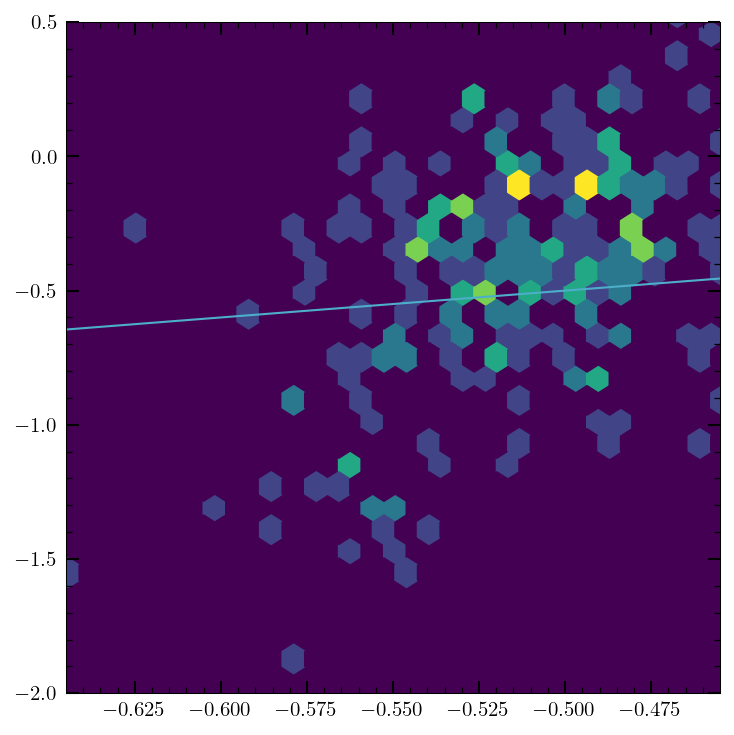

In [42]:
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=30)
plt.plot([-2, 1], [-2, 1])
axes.set(xlim=(-0.645, -0.455), ylim=(-2, 0.5))

In [45]:
data_length = len(cleaned_photodf_nohalpha)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = preprocessing.RobustScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = preprocessing.RobustScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

750
number of epochs 2000
epoch 0
loss 0.5271353721618652
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.0427. Test accuracy: 0.036
epoch 1
loss 0.5264444947242737
epoch 2
loss 0.5257763862609863
epoch 3
loss 0.5251310467720032
epoch 4
loss 0.5244988799095154
epoch 5
loss 0.5238808393478394
 EPOCH 5. Progress: 0.25%. 
 Train accuracy: 0.0413. Test accuracy: 0.04
epoch 6
loss 0.5232744812965393
epoch 7
loss 0.5226765871047974
epoch 8
loss 0.5220833420753479
epoch 9
loss 0.5214943885803223
epoch 10
loss 0.5209088325500488
 EPOCH 10. Progress: 0.5%. 
 Train accuracy: 0.0413. Test accuracy: 0.036
epoch 11
loss 0.5203248858451843
epoch 12
loss 0.5197360515594482
epoch 13
loss 0.5191398859024048
epoch 14
loss 0.5185444355010986
epoch 15
loss 0.5179487466812134
 EPOCH 15. Progress: 0.75%. 
 Train accuracy: 0.0427. Test accuracy: 0.04
epoch 16
loss 0.5173546671867371
epoch 17
loss 0.5167580842971802
epoch 18
loss 0.516168475151062
epoch 19
loss 0.5155837535858154
epoch 20
loss 0.515002787113189

loss 0.4274294376373291
epoch 174
loss 0.4269252419471741
epoch 175
loss 0.42642125487327576
 EPOCH 175. Progress: 8.75%. 
 Train accuracy: 0.0453. Test accuracy: 0.068
epoch 176
loss 0.4259191155433655
epoch 177
loss 0.42541420459747314
epoch 178
loss 0.4249097406864166
epoch 179
loss 0.42440658807754517
epoch 180
loss 0.42390361428260803
 EPOCH 180. Progress: 9.0%. 
 Train accuracy: 0.0467. Test accuracy: 0.072
epoch 181
loss 0.4234005808830261
epoch 182
loss 0.42289867997169495
epoch 183
loss 0.4223936200141907
epoch 184
loss 0.42188751697540283
epoch 185
loss 0.42138177156448364
 EPOCH 185. Progress: 9.25%. 
 Train accuracy: 0.0493. Test accuracy: 0.072
epoch 186
loss 0.42087626457214355
epoch 187
loss 0.42036858201026917
epoch 188
loss 0.4198616147041321
epoch 189
loss 0.4193604290485382
epoch 190
loss 0.4188553988933563
 EPOCH 190. Progress: 9.5%. 
 Train accuracy: 0.0493. Test accuracy: 0.072
epoch 191
loss 0.4183486998081207
epoch 192
loss 0.41784077882766724
epoch 193
loss 0.4

loss 0.34736692905426025
 EPOCH 345. Progress: 17.25%. 
 Train accuracy: 0.0507. Test accuracy: 0.04
epoch 346
loss 0.346991628408432
epoch 347
loss 0.3466111719608307
epoch 348
loss 0.3462299704551697
epoch 349
loss 0.34585830569267273
epoch 350
loss 0.3454877436161041
 EPOCH 350. Progress: 17.5%. 
 Train accuracy: 0.048. Test accuracy: 0.044
epoch 351
loss 0.34511634707450867
epoch 352
loss 0.34474822878837585
epoch 353
loss 0.34438201785087585
epoch 354
loss 0.3440106213092804
epoch 355
loss 0.34364768862724304
 EPOCH 355. Progress: 17.75%. 
 Train accuracy: 0.048. Test accuracy: 0.048
epoch 356
loss 0.34328335523605347
epoch 357
loss 0.342924028635025
epoch 358
loss 0.34256210923194885
epoch 359
loss 0.3422046899795532
epoch 360
loss 0.34185031056404114
 EPOCH 360. Progress: 18.0%. 
 Train accuracy: 0.0467. Test accuracy: 0.048
epoch 361
loss 0.341492623090744
epoch 362
loss 0.34114065766334534
epoch 363
loss 0.3407878577709198
epoch 364
loss 0.3404395282268524
epoch 365
loss 0.340

 EPOCH 510. Progress: 25.5%. 
 Train accuracy: 0.0693. Test accuracy: 0.072
epoch 511
loss 0.30419012904167175
epoch 512
loss 0.3040275275707245
epoch 513
loss 0.30386340618133545
epoch 514
loss 0.3036949634552002
epoch 515
loss 0.30353105068206787
 EPOCH 515. Progress: 25.75%. 
 Train accuracy: 0.0693. Test accuracy: 0.072
epoch 516
loss 0.30336830019950867
epoch 517
loss 0.30320513248443604
epoch 518
loss 0.3030473291873932
epoch 519
loss 0.3028888702392578
epoch 520
loss 0.3027278482913971
 EPOCH 520. Progress: 26.0%. 
 Train accuracy: 0.0667. Test accuracy: 0.072
epoch 521
loss 0.3025672435760498
epoch 522
loss 0.3024096190929413
epoch 523
loss 0.30225399136543274
epoch 524
loss 0.3020908236503601
epoch 525
loss 0.30193325877189636
 EPOCH 525. Progress: 26.25%. 
 Train accuracy: 0.0667. Test accuracy: 0.068
epoch 526
loss 0.30177733302116394
epoch 527
loss 0.30162495374679565
epoch 528
loss 0.3014809489250183
epoch 529
loss 0.3013387620449066
epoch 530
loss 0.3011949360370636
 EPOC

loss 0.28356295824050903
epoch 679
loss 0.2834731638431549
epoch 680
loss 0.28337639570236206
 EPOCH 680. Progress: 34.0%. 
 Train accuracy: 0.068. Test accuracy: 0.072
epoch 681
loss 0.2832843065261841
epoch 682
loss 0.28318846225738525
epoch 683
loss 0.2830985188484192
epoch 684
loss 0.28300604224205017
epoch 685
loss 0.2829156517982483
 EPOCH 685. Progress: 34.25%. 
 Train accuracy: 0.068. Test accuracy: 0.072
epoch 686
loss 0.28282424807548523
epoch 687
loss 0.2827354669570923
epoch 688
loss 0.28263571858406067
epoch 689
loss 0.2825409471988678
epoch 690
loss 0.2824472188949585
 EPOCH 690. Progress: 34.5%. 
 Train accuracy: 0.0667. Test accuracy: 0.072
epoch 691
loss 0.28235355019569397
epoch 692
loss 0.2822563350200653
epoch 693
loss 0.2821608781814575
epoch 694
loss 0.28206828236579895
epoch 695
loss 0.28197360038757324
 EPOCH 695. Progress: 34.75%. 
 Train accuracy: 0.0667. Test accuracy: 0.072
epoch 696
loss 0.281887024641037
epoch 697
loss 0.2817968428134918
epoch 698
loss 0.2

loss 0.27260661125183105
 EPOCH 845. Progress: 42.25%. 
 Train accuracy: 0.0627. Test accuracy: 0.084
epoch 846
loss 0.2725602388381958
epoch 847
loss 0.2725227475166321
epoch 848
loss 0.27248939871788025
epoch 849
loss 0.27244749665260315
epoch 850
loss 0.2724083960056305
 EPOCH 850. Progress: 42.5%. 
 Train accuracy: 0.0627. Test accuracy: 0.084
epoch 851
loss 0.2723620533943176
epoch 852
loss 0.2723192572593689
epoch 853
loss 0.27228522300720215
epoch 854
loss 0.27223625779151917
epoch 855
loss 0.27220261096954346
 EPOCH 855. Progress: 42.75%. 
 Train accuracy: 0.064. Test accuracy: 0.084
epoch 856
loss 0.27216607332229614
epoch 857
loss 0.2721216082572937
epoch 858
loss 0.27207833528518677
epoch 859
loss 0.2720581889152527
epoch 860
loss 0.27201253175735474
 EPOCH 860. Progress: 43.0%. 
 Train accuracy: 0.064. Test accuracy: 0.088
epoch 861
loss 0.27197352051734924
epoch 862
loss 0.27193984389305115
epoch 863
loss 0.2718956470489502
epoch 864
loss 0.2718542814254761
epoch 865
loss 

loss 0.267691433429718
epoch 1014
loss 0.26766258478164673
epoch 1015
loss 0.2676423192024231
 EPOCH 1015. Progress: 50.74999999999999%. 
 Train accuracy: 0.056. Test accuracy: 0.072
epoch 1016
loss 0.2676219046115875
epoch 1017
loss 0.2675996720790863
epoch 1018
loss 0.26758086681365967
epoch 1019
loss 0.26755058765411377
epoch 1020
loss 0.267528235912323
 EPOCH 1020. Progress: 51.0%. 
 Train accuracy: 0.0587. Test accuracy: 0.072
epoch 1021
loss 0.26750391721725464
epoch 1022
loss 0.2674812972545624
epoch 1023
loss 0.2674591839313507
epoch 1024
loss 0.26743993163108826
epoch 1025
loss 0.2674142122268677
 EPOCH 1025. Progress: 51.24999999999999%. 
 Train accuracy: 0.0587. Test accuracy: 0.072
epoch 1026
loss 0.2673955261707306
epoch 1027
loss 0.26737141609191895
epoch 1028
loss 0.26735344529151917
epoch 1029
loss 0.26734238862991333
epoch 1030
loss 0.26732322573661804
 EPOCH 1030. Progress: 51.5%. 
 Train accuracy: 0.0587. Test accuracy: 0.072
epoch 1031
loss 0.26730772852897644
epoch

loss 0.2661871910095215
 EPOCH 1175. Progress: 58.75%. 
 Train accuracy: 0.06. Test accuracy: 0.064
epoch 1176
loss 0.2661705017089844
epoch 1177
loss 0.266166090965271
epoch 1178
loss 0.26615944504737854
epoch 1179
loss 0.2661486566066742
epoch 1180
loss 0.26613375544548035
 EPOCH 1180. Progress: 59.0%. 
 Train accuracy: 0.0613. Test accuracy: 0.064
epoch 1181
loss 0.266131192445755
epoch 1182
loss 0.26611897349357605
epoch 1183
loss 0.266107439994812
epoch 1184
loss 0.2661035656929016
epoch 1185
loss 0.26609253883361816
 EPOCH 1185. Progress: 59.25%. 
 Train accuracy: 0.0613. Test accuracy: 0.064
epoch 1186
loss 0.2660810947418213
epoch 1187
loss 0.26607823371887207
epoch 1188
loss 0.2660694122314453
epoch 1189
loss 0.2660571336746216
epoch 1190
loss 0.2660442292690277
 EPOCH 1190. Progress: 59.5%. 
 Train accuracy: 0.0613. Test accuracy: 0.064
epoch 1191
loss 0.26603958010673523
epoch 1192
loss 0.26602867245674133
epoch 1193
loss 0.26601794362068176
epoch 1194
loss 0.266009151935577

 EPOCH 1340. Progress: 67.0%. 
 Train accuracy: 0.072. Test accuracy: 0.076
epoch 1341
loss 0.2648717164993286
epoch 1342
loss 0.26486873626708984
epoch 1343
loss 0.264859139919281
epoch 1344
loss 0.2648483216762543
epoch 1345
loss 0.26484164595603943
 EPOCH 1345. Progress: 67.25%. 
 Train accuracy: 0.072. Test accuracy: 0.072
epoch 1346
loss 0.2648369073867798
epoch 1347
loss 0.26482468843460083
epoch 1348
loss 0.2648142874240875
epoch 1349
loss 0.26480552554130554
epoch 1350
loss 0.2647964060306549
 EPOCH 1350. Progress: 67.5%. 
 Train accuracy: 0.072. Test accuracy: 0.072
epoch 1351
loss 0.26479119062423706
epoch 1352
loss 0.2647796869277954
epoch 1353
loss 0.26476967334747314
epoch 1354
loss 0.2647644877433777
epoch 1355
loss 0.2647404968738556
 EPOCH 1355. Progress: 67.75%. 
 Train accuracy: 0.072. Test accuracy: 0.072
epoch 1356
loss 0.26473522186279297
epoch 1357
loss 0.26472464203834534
epoch 1358
loss 0.2647189795970917
epoch 1359
loss 0.2647112011909485
epoch 1360
loss 0.2646

 EPOCH 1505. Progress: 75.25%. 
 Train accuracy: 0.0667. Test accuracy: 0.064
epoch 1506
loss 0.26386967301368713
epoch 1507
loss 0.26384633779525757
epoch 1508
loss 0.26383349299430847
epoch 1509
loss 0.2638172209262848
epoch 1510
loss 0.2638057768344879
 EPOCH 1510. Progress: 75.5%. 
 Train accuracy: 0.0667. Test accuracy: 0.064
epoch 1511
loss 0.26379314064979553
epoch 1512
loss 0.2637788951396942
epoch 1513
loss 0.2637634575366974
epoch 1514
loss 0.2637489438056946
epoch 1515
loss 0.2637273669242859
 EPOCH 1515. Progress: 75.75%. 
 Train accuracy: 0.0667. Test accuracy: 0.068
epoch 1516
loss 0.26372405886650085
epoch 1517
loss 0.26371321082115173
epoch 1518
loss 0.26369282603263855
epoch 1519
loss 0.26368415355682373
epoch 1520
loss 0.2636682987213135
 EPOCH 1520. Progress: 76.0%. 
 Train accuracy: 0.068. Test accuracy: 0.068
epoch 1521
loss 0.2636525630950928
epoch 1522
loss 0.2636464834213257
epoch 1523
loss 0.2636311948299408
epoch 1524
loss 0.2636193335056305
epoch 1525
loss 0.

 EPOCH 1670. Progress: 83.5%. 
 Train accuracy: 0.0693. Test accuracy: 0.064
epoch 1671
loss 0.26072579622268677
epoch 1672
loss 0.26069942116737366
epoch 1673
loss 0.2606983482837677
epoch 1674
loss 0.26067212224006653
epoch 1675
loss 0.2606571614742279
 EPOCH 1675. Progress: 83.75%. 
 Train accuracy: 0.0693. Test accuracy: 0.064
epoch 1676
loss 0.2606464624404907
epoch 1677
loss 0.2606235444545746
epoch 1678
loss 0.2606102526187897
epoch 1679
loss 0.2605982720851898
epoch 1680
loss 0.2605783939361572
 EPOCH 1680. Progress: 84.0%. 
 Train accuracy: 0.0693. Test accuracy: 0.064
epoch 1681
loss 0.2605394423007965
epoch 1682
loss 0.2605208158493042
epoch 1683
loss 0.2605137526988983
epoch 1684
loss 0.260489284992218
epoch 1685
loss 0.26046767830848694
 EPOCH 1685. Progress: 84.25%. 
 Train accuracy: 0.068. Test accuracy: 0.064
epoch 1686
loss 0.26044678688049316
epoch 1687
loss 0.2604108452796936
epoch 1688
loss 0.2604023814201355
epoch 1689
loss 0.26037800312042236
epoch 1690
loss 0.260

loss 0.25773799419403076
epoch 1838
loss 0.2577214241027832
epoch 1839
loss 0.25770658254623413
epoch 1840
loss 0.25768187642097473
 EPOCH 1840. Progress: 92.0%. 
 Train accuracy: 0.0653. Test accuracy: 0.06
epoch 1841
loss 0.2576645612716675
epoch 1842
loss 0.25765469670295715
epoch 1843
loss 0.25763386487960815
epoch 1844
loss 0.2576174736022949
epoch 1845
loss 0.25759515166282654
 EPOCH 1845. Progress: 92.25%. 
 Train accuracy: 0.0653. Test accuracy: 0.06
epoch 1846
loss 0.25757160782814026
epoch 1847
loss 0.25755369663238525
epoch 1848
loss 0.2575368881225586
epoch 1849
loss 0.2575068473815918
epoch 1850
loss 0.25748419761657715
 EPOCH 1850. Progress: 92.5%. 
 Train accuracy: 0.0653. Test accuracy: 0.06
epoch 1851
loss 0.25745707750320435
epoch 1852
loss 0.2574387192726135
epoch 1853
loss 0.2574124038219452
epoch 1854
loss 0.2573772072792053
epoch 1855
loss 0.2573544383049011
 EPOCH 1855. Progress: 92.75%. 
 Train accuracy: 0.0667. Test accuracy: 0.06
epoch 1856
loss 0.257335364818

In [ ]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:
        #print(data)
        #print(data.shape)
        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        #print(output.detach().numpy())
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])

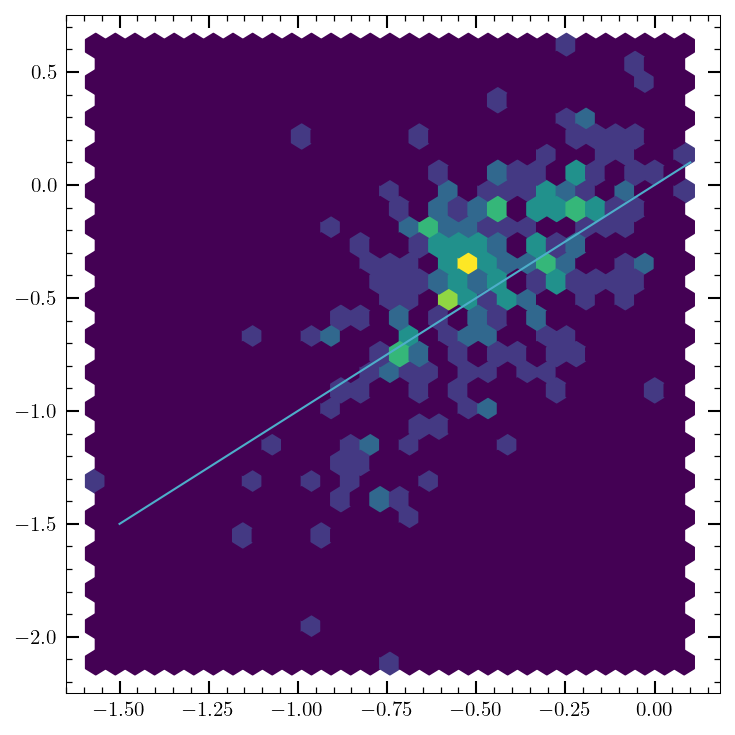

In [48]:
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=30)
plt.plot([-1.5, 0.1], [-1.5, .1])
#axes.set(xlim=(-0.645, -0.455), ylim=(-2, 0.5))

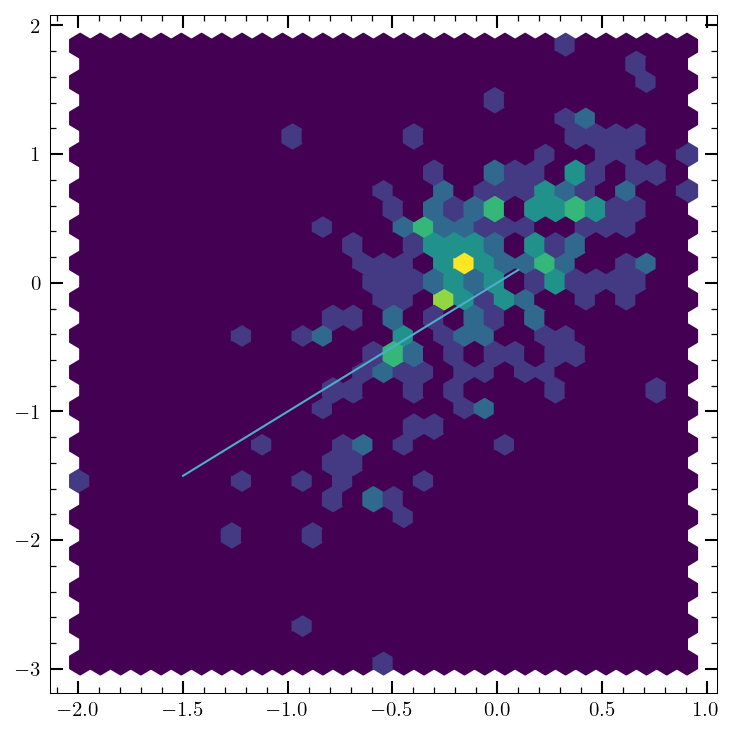

In [49]:
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1.5, 0.1], [-1.5, .1])
#axes.set(xlim=(-0.645, -0.455), ylim=(-2, 0.5))

In [53]:
data_length = len(cleaned_photodf_nohalpha)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = preprocessing.RobustScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = preprocessing.RobustScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.0001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

750
number of epochs 2000
loss 0.5505064129829407
 EPOCH 0. Train accuracy: 0.2867. Test accuracy: 0.292
loss 0.5501496195793152
loss 0.5497965812683105
loss 0.5494463443756104
loss 0.5490994453430176
loss 0.548755943775177
loss 0.5484157800674438
loss 0.5480788946151733
loss 0.5477454662322998
loss 0.5474151372909546
loss 0.5470882654190063
 EPOCH 10. Train accuracy: 0.2867. Test accuracy: 0.296
loss 0.5467641353607178
loss 0.5464427471160889
loss 0.5461245179176331
loss 0.5458097457885742
loss 0.5454979538917542
loss 0.5451891422271729
loss 0.5448833703994751
loss 0.5445806980133057
loss 0.5442812442779541
loss 0.5439843535423279
 EPOCH 20. Train accuracy: 0.2853. Test accuracy: 0.304
loss 0.5436899065971375
loss 0.5433981418609619
loss 0.5431092977523804
loss 0.542823076248169
loss 0.5425398349761963
loss 0.5422593951225281
loss 0.5419816970825195
loss 0.5417066812515259
loss 0.5414342880249023
loss 0.5411644577980042
 EPOCH 30. Train accuracy: 0.2827. Test accuracy: 0.304
loss 0.54

 EPOCH 280. Train accuracy: 0.2667. Test accuracy: 0.252
loss 0.5130288004875183
loss 0.5129775404930115
loss 0.5129263997077942
loss 0.5128753781318665
loss 0.5128244161605835
loss 0.5127735733985901
loss 0.5127226114273071
loss 0.5126717686653137
loss 0.5126209259033203
loss 0.5125702023506165
 EPOCH 290. Train accuracy: 0.2627. Test accuracy: 0.252
loss 0.5125196576118469
loss 0.5124691128730774
loss 0.5124185681343079
loss 0.5123681426048279
loss 0.5123178362846375
loss 0.512267529964447
loss 0.5122174024581909
loss 0.5121673345565796
loss 0.5121174454689026
loss 0.5120675563812256
 EPOCH 300. Train accuracy: 0.26. Test accuracy: 0.248
loss 0.5120177268981934
loss 0.5119678974151611
loss 0.5119181275367737
loss 0.5118685364723206
loss 0.5118191242218018
loss 0.5117699503898621
loss 0.5117208957672119
loss 0.5116719007492065
loss 0.5116229057312012
loss 0.5115740895271301
 EPOCH 310. Train accuracy: 0.2613. Test accuracy: 0.252
loss 0.5115252733230591
loss 0.5114763975143433
loss 0.

loss 0.49835965037345886
loss 0.498300701379776
loss 0.49824169278144836
loss 0.4981827139854431
loss 0.4981236159801483
loss 0.49806448817253113
loss 0.49800536036491394
loss 0.49794620275497437
 EPOCH 570. Train accuracy: 0.248. Test accuracy: 0.24
loss 0.49788692593574524
loss 0.49782776832580566
loss 0.4977685213088989
loss 0.497709184885025
loss 0.4976498782634735
loss 0.497590571641922
loss 0.49753111600875854
loss 0.49747177958488464
loss 0.49741241335868835
loss 0.49735304713249207
 EPOCH 580. Train accuracy: 0.2467. Test accuracy: 0.24
loss 0.4972935616970062
loss 0.4972341060638428
loss 0.4971746802330017
loss 0.4971151053905487
loss 0.49705544114112854
loss 0.49699580669403076
loss 0.49693620204925537
loss 0.4968763589859009
loss 0.4968165159225464
loss 0.4967566430568695
 EPOCH 590. Train accuracy: 0.2453. Test accuracy: 0.24
loss 0.4966967701911926
loss 0.4966369569301605
loss 0.49657702445983887
loss 0.4965170919895172
loss 0.4964570999145508
loss 0.4963969886302948
loss 

loss 0.48069068789482117
loss 0.48062124848365784
loss 0.4805518686771393
 EPOCH 840. Train accuracy: 0.252. Test accuracy: 0.244
loss 0.48048239946365356
loss 0.4804129898548126
loss 0.48034346103668213
loss 0.4802740216255188
loss 0.4802045524120331
loss 0.4801349341869354
loss 0.480065256357193
loss 0.47999560832977295
loss 0.4799259901046753
loss 0.47985634207725525
 EPOCH 850. Train accuracy: 0.2533. Test accuracy: 0.244
loss 0.47978675365448
loss 0.4797172546386719
loss 0.47964760661125183
loss 0.479577898979187
loss 0.47950831055641174
loss 0.4794386029243469
loss 0.47936880588531494
loss 0.4792991280555725
loss 0.4792293906211853
loss 0.4791596531867981
 EPOCH 860. Train accuracy: 0.2533. Test accuracy: 0.244
loss 0.4790898859500885
loss 0.4790200889110565
loss 0.4789503216743469
loss 0.47888049483299255
loss 0.4788106083869934
loss 0.47874078154563904
loss 0.4786708354949951
loss 0.4786008596420288
loss 0.47853076457977295
loss 0.4784608483314514
 EPOCH 870. Train accuracy: 0.

loss 0.46110084652900696
loss 0.461028128862381
loss 0.46095553040504456
loss 0.46088287234306335
loss 0.46081024408340454
loss 0.4607376158237457
loss 0.4606649875640869
loss 0.4605923593044281
 EPOCH 1120. Train accuracy: 0.2587. Test accuracy: 0.26
loss 0.46051979064941406
loss 0.4604475498199463
loss 0.46037527918815613
loss 0.4603029489517212
loss 0.46023067831993103
loss 0.4601583778858185
loss 0.4600861668586731
loss 0.4600139558315277
loss 0.45994168519973755
loss 0.45986947417259216
 EPOCH 1130. Train accuracy: 0.2587. Test accuracy: 0.26
loss 0.45979729294776917
loss 0.459725022315979
loss 0.45965272188186646
loss 0.45958054065704346
loss 0.4595082998275757
loss 0.45943599939346313
loss 0.4593636691570282
loss 0.45929136872291565
loss 0.4592190682888031
loss 0.459146648645401
 EPOCH 1140. Train accuracy: 0.26. Test accuracy: 0.26
loss 0.4590742886066437
loss 0.45900189876556396
loss 0.45892947912216187
loss 0.45885708928108215
loss 0.45878463983535767
loss 0.45871230959892273

loss 0.44083771109580994
loss 0.4407634735107422
loss 0.44068920612335205
 EPOCH 1390. Train accuracy: 0.2613. Test accuracy: 0.26
loss 0.4406149387359619
loss 0.440540611743927
loss 0.44046637415885925
loss 0.4403921067714691
loss 0.4403178095817566
loss 0.4402434229850769
loss 0.4401690363883972
loss 0.4400945007801056
loss 0.44001996517181396
loss 0.43994539976119995
 EPOCH 1400. Train accuracy: 0.2613. Test accuracy: 0.26
loss 0.43987083435058594
loss 0.4397962689399719
loss 0.4397216737270355
loss 0.4396471083164215
loss 0.43957260251045227
loss 0.43949803709983826
loss 0.439423531293869
loss 0.4393489956855774
loss 0.4392744302749634
loss 0.439199835062027
 EPOCH 1410. Train accuracy: 0.2613. Test accuracy: 0.26
loss 0.43912529945373535
loss 0.4390507936477661
loss 0.4389762878417969
loss 0.43890178203582764
loss 0.4388272762298584
loss 0.438752681016922
loss 0.4386782944202423
loss 0.4386042654514313
loss 0.43853020668029785
loss 0.43845614790916443
 EPOCH 1420. Train accuracy: 

loss 0.4210517108440399
loss 0.420980840921402
loss 0.4209100604057312
loss 0.42083922028541565
loss 0.4207684397697449
loss 0.4206976294517517
loss 0.42062681913375854
loss 0.42055606842041016
loss 0.4204851984977722
loss 0.42041435837745667
 EPOCH 1670. Train accuracy: 0.2733. Test accuracy: 0.26
loss 0.4203434884548187
loss 0.4202726483345032
loss 0.4202018082141876
loss 0.42013102769851685
loss 0.42006033658981323
loss 0.41998955607414246
loss 0.41991886496543884
loss 0.41984817385673523
loss 0.419777512550354
loss 0.41970688104629517
 EPOCH 1680. Train accuracy: 0.2733. Test accuracy: 0.256
loss 0.41963616013526917
loss 0.41956546902656555
loss 0.41949477791786194
loss 0.41942405700683594
loss 0.41935333609580994
loss 0.4192825257778168
loss 0.41921180486679077
loss 0.41914108395576477
loss 0.41907036304473877
loss 0.418999582529068
 EPOCH 1690. Train accuracy: 0.272. Test accuracy: 0.256
loss 0.418928861618042
loss 0.4188581109046936
loss 0.41878753900527954
loss 0.41871693730354

loss 0.4021272659301758
loss 0.402059942483902
loss 0.40199264883995056
loss 0.4019254446029663
loss 0.40185824036598206
loss 0.40179115533828735
loss 0.4017240107059479
 EPOCH 1940. Train accuracy: 0.272. Test accuracy: 0.264
loss 0.40165695548057556
loss 0.40158990025520325
loss 0.40152278542518616
loss 0.40145573019981384
loss 0.4013887345790863
loss 0.4013217091560364
loss 0.40125468373298645
loss 0.4011877477169037
loss 0.40112078189849854
loss 0.40105393528938293
 EPOCH 1950. Train accuracy: 0.272. Test accuracy: 0.264
loss 0.4009871184825897
loss 0.40092021226882935
loss 0.4008534252643585
loss 0.40078651905059814
loss 0.4007197320461273
loss 0.40065285563468933
loss 0.4005858898162842
loss 0.4005189836025238
loss 0.4004521667957306
loss 0.400385320186615
 EPOCH 1960. Train accuracy: 0.272. Test accuracy: 0.264
loss 0.40031853318214417
loss 0.4002517759799957
loss 0.40018516778945923
loss 0.4001185894012451
loss 0.40005210041999817
loss 0.3999856114387512
loss 0.3999192118644714

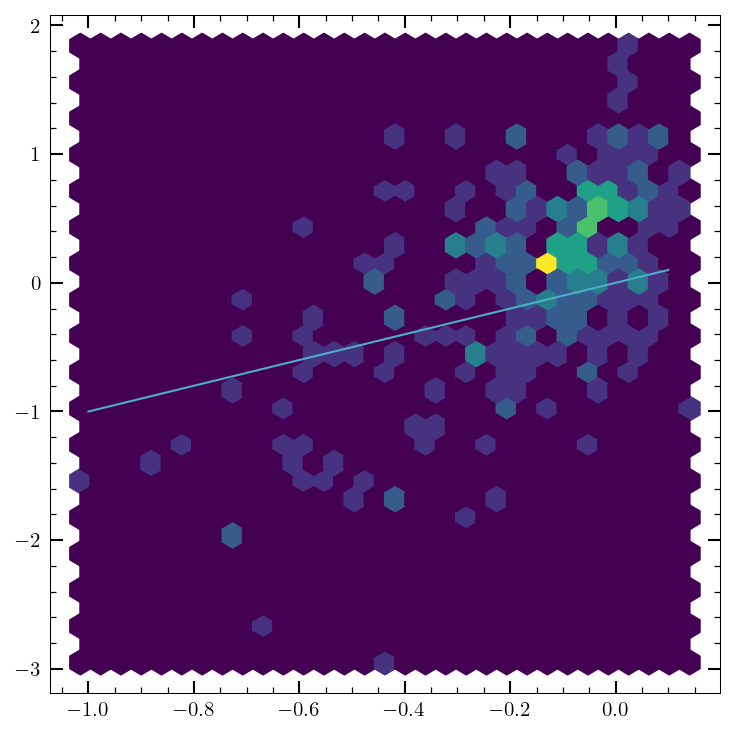

In [55]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:
        #print(data)
        #print(data.shape)
        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        #print(output.detach().numpy())
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])
#axes.set(xlim=(-0.645, -0.455), ylim=(-2, 0.5))

In [64]:
data_length = len(cleaned_photodf_nohalpha)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = preprocessing.RobustScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = preprocessing.RobustScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.0001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

750
number of epochs 5000
loss 0.5621017813682556
 EPOCH 0. Train accuracy: 0.2747. Test accuracy: 0.2575
loss 0.5617291331291199
loss 0.5613593459129333
loss 0.5609920024871826
loss 0.5606248378753662
loss 0.5602602958679199
loss 0.5598985552787781
loss 0.5595402121543884
loss 0.5591844916343689
loss 0.5588315725326538
loss 0.5584800243377686
 EPOCH 10. Train accuracy: 0.2773. Test accuracy: 0.2525
loss 0.558129072189331
loss 0.5577804446220398
loss 0.5574342608451843
loss 0.5570903420448303
loss 0.556749165058136
loss 0.5564095377922058
loss 0.5560703277587891
loss 0.5557332038879395
loss 0.5553984642028809
loss 0.5550657510757446
 EPOCH 20. Train accuracy: 0.2827. Test accuracy: 0.2525
loss 0.5547351241111755
loss 0.5544064044952393
loss 0.554078996181488
loss 0.5537527203559875
loss 0.553428590297699
loss 0.5531065464019775
loss 0.5527865886688232
loss 0.5524685382843018
loss 0.5521524548530579
loss 0.5518386960029602
 EPOCH 30. Train accuracy: 0.284. Test accuracy: 0.2475
loss 0.5

loss 0.5038756132125854
loss 0.5037459135055542
loss 0.503616452217102
 EPOCH 280. Train accuracy: 0.2547. Test accuracy: 0.225
loss 0.5034871101379395
loss 0.5033579468727112
loss 0.503229022026062
loss 0.5031003355979919
loss 0.5029718279838562
loss 0.5028434991836548
loss 0.5027153491973877
loss 0.5025875568389893
loss 0.5024598836898804
loss 0.502332329750061
 EPOCH 290. Train accuracy: 0.2533. Test accuracy: 0.225
loss 0.5022050738334656
loss 0.5020778775215149
loss 0.5019509196281433
loss 0.5018242001533508
loss 0.5016976594924927
loss 0.5015712976455688
loss 0.5014450550079346
loss 0.5013191103935242
loss 0.5011933445930481
loss 0.5010676980018616
 EPOCH 300. Train accuracy: 0.2533. Test accuracy: 0.2275
loss 0.500942587852478
loss 0.5008175373077393
loss 0.5006923675537109
loss 0.5005673766136169
loss 0.5004426836967468
loss 0.5003179311752319
loss 0.5001934170722961
loss 0.5000691413879395
loss 0.4999450743198395
loss 0.4998212456703186
 EPOCH 310. Train accuracy: 0.2533. Test

loss 0.4739976227283478
loss 0.4739028513431549
loss 0.47380825877189636
loss 0.47371360659599304
loss 0.47361910343170166
loss 0.47352465987205505
loss 0.473430335521698
loss 0.47333621978759766
loss 0.4732421040534973
loss 0.47314804792404175
 EPOCH 560. Train accuracy: 0.2533. Test accuracy: 0.2425
loss 0.47305381298065186
loss 0.4729597568511963
loss 0.4728657603263855
loss 0.4727718234062195
loss 0.4726780652999878
loss 0.4725842773914337
loss 0.4724906086921692
loss 0.47239699959754944
loss 0.4723034203052521
loss 0.47220996022224426
 EPOCH 570. Train accuracy: 0.252. Test accuracy: 0.2425
loss 0.47211670875549316
loss 0.4720233976840973
loss 0.47193020582199097
loss 0.4718371629714966
loss 0.47174400091171265
loss 0.47165119647979736
loss 0.471558541059494
loss 0.4714658856391907
loss 0.4713732898235321
loss 0.47128087282180786
 EPOCH 580. Train accuracy: 0.2547. Test accuracy: 0.2425
loss 0.47118839621543884
loss 0.47109612822532654
loss 0.47100377082824707
loss 0.4709115922451

loss 0.45064684748649597
loss 0.45057010650634766
loss 0.4504934251308441
loss 0.4504166841506958
loss 0.45034003257751465
 EPOCH 830. Train accuracy: 0.2627. Test accuracy: 0.235
loss 0.4502634108066559
loss 0.4501868486404419
loss 0.45011043548583984
loss 0.4500340223312378
loss 0.4499576687812805
loss 0.449881374835968
loss 0.4498051404953003
loss 0.44972896575927734
loss 0.44965285062789917
loss 0.44957679510116577
 EPOCH 840. Train accuracy: 0.2627. Test accuracy: 0.235
loss 0.4495008885860443
loss 0.44942501187324524
loss 0.44934922456741333
loss 0.44927340745925903
loss 0.4491977393627167
loss 0.44912204146385193
loss 0.4490464925765991
loss 0.4489709436893463
loss 0.4488954246044159
loss 0.44881999492645264
 EPOCH 850. Train accuracy: 0.2613. Test accuracy: 0.2375
loss 0.44874465465545654
loss 0.44866928458213806
loss 0.44859400391578674
loss 0.4485187828540802
loss 0.44844359159469604
loss 0.44836845993995667
loss 0.44829344749450684
loss 0.4482184648513794
loss 0.448143512010

loss 0.43166497349739075
loss 0.4316011071205139
loss 0.4315372407436371
 EPOCH 1100. Train accuracy: 0.272. Test accuracy: 0.2375
loss 0.4314734637737274
loss 0.43140968680381775
loss 0.43134593963623047
loss 0.4312822222709656
loss 0.43121856451034546
loss 0.43115493655204773
loss 0.4310915470123291
loss 0.4310280680656433
loss 0.4309646189212799
loss 0.43090125918388367
 EPOCH 1110. Train accuracy: 0.272. Test accuracy: 0.235
loss 0.4308379888534546
loss 0.4307747781276703
loss 0.430711567401886
loss 0.43064841628074646
loss 0.4305853545665741
loss 0.43052226305007935
loss 0.430459201335907
loss 0.4303962290287018
loss 0.4303332567214966
loss 0.43027037382125854
 EPOCH 1120. Train accuracy: 0.272. Test accuracy: 0.235
loss 0.4302075207233429
loss 0.43014466762542725
loss 0.43008187413215637
loss 0.4300190806388855
loss 0.429956316947937
loss 0.4298936426639557
loss 0.42983099818229675
loss 0.429768443107605
loss 0.4297058582305908
loss 0.42964333295822144
 EPOCH 1130. Train accuracy

loss 0.4154265224933624
loss 0.4153720438480377
loss 0.41531768441200256
loss 0.41526320576667786
loss 0.4152089059352875
loss 0.41515448689460754
loss 0.41510000824928284
 EPOCH 1380. Train accuracy: 0.272. Test accuracy: 0.24
loss 0.41504570841789246
loss 0.4149913489818573
loss 0.41493698954582214
loss 0.41488274931907654
loss 0.41482847929000854
loss 0.4147742986679077
loss 0.4147200286388397
loss 0.4146658778190613
loss 0.41461169719696045
loss 0.414557546377182
 EPOCH 1390. Train accuracy: 0.272. Test accuracy: 0.24
loss 0.4145032465457916
loss 0.41444897651672363
loss 0.41439467668533325
loss 0.41434043645858765
loss 0.41428616642951965
loss 0.41423189640045166
loss 0.41417765617370605
loss 0.41412338614463806
loss 0.41406917572021484
loss 0.41401490569114685
 EPOCH 1400. Train accuracy: 0.272. Test accuracy: 0.24
loss 0.4139607548713684
loss 0.41390660405158997
loss 0.41385239362716675
loss 0.4137982428073883
loss 0.4137442409992218
loss 0.4136901795864105
loss 0.41363623738288

loss 0.40111538767814636
 EPOCH 1650. Train accuracy: 0.2733. Test accuracy: 0.2425
loss 0.40106597542762756
loss 0.4010166525840759
loss 0.40096721053123474
loss 0.40091782808303833
loss 0.4008685052394867
loss 0.40081918239593506
loss 0.40076979994773865
loss 0.400720477104187
loss 0.4006710946559906
loss 0.4006216824054718
 EPOCH 1660. Train accuracy: 0.2733. Test accuracy: 0.2425
loss 0.4005722403526306
loss 0.4005228281021118
loss 0.400473415851593
loss 0.40042397379875183
loss 0.40037456154823303
loss 0.4003251791000366
loss 0.4002758860588074
loss 0.40022650361061096
loss 0.4001771807670593
loss 0.4001278579235077
 EPOCH 1670. Train accuracy: 0.2733. Test accuracy: 0.2425
loss 0.40007859468460083
loss 0.40002936124801636
loss 0.3999800980091095
loss 0.399930864572525
loss 0.39988163113594055
loss 0.3998323678970337
loss 0.3997832238674164
loss 0.3997339606285095
loss 0.39968475699424744
loss 0.39963555335998535
 EPOCH 1680. Train accuracy: 0.2733. Test accuracy: 0.2425
loss 0.39

loss 0.3878304660320282
loss 0.3877832889556885
 EPOCH 1930. Train accuracy: 0.2773. Test accuracy: 0.2475
loss 0.3877359628677368
loss 0.3876888155937195
loss 0.3876416087150574
loss 0.3875943422317505
loss 0.387547105550766
loss 0.3874998092651367
loss 0.3874525725841522
loss 0.38740527629852295
loss 0.38735806941986084
loss 0.38731083273887634
 EPOCH 1940. Train accuracy: 0.2773. Test accuracy: 0.2475
loss 0.387263685464859
loss 0.3872164785861969
loss 0.38716942071914673
loss 0.3871222734451294
loss 0.38707518577575684
loss 0.3870280981063843
loss 0.3869810402393341
loss 0.38693398237228394
loss 0.386886864900589
loss 0.38683974742889404
 EPOCH 1950. Train accuracy: 0.276. Test accuracy: 0.2475
loss 0.3867926299571991
loss 0.38674554228782654
loss 0.3866983652114868
loss 0.3866512179374695
loss 0.38660407066345215
loss 0.3865568935871124
loss 0.3865097165107727
loss 0.38646239042282104
loss 0.38641518354415894
loss 0.38636791706085205
 EPOCH 1960. Train accuracy: 0.276. Test accura

loss 0.37462878227233887
loss 0.37458133697509766
loss 0.37453392148017883
 EPOCH 2210. Train accuracy: 0.28. Test accuracy: 0.2475
loss 0.3744864761829376
loss 0.374439001083374
loss 0.3743914067745209
loss 0.3743438422679901
loss 0.3742961883544922
loss 0.3742486536502838
loss 0.37420108914375305
loss 0.3741535544395447
loss 0.3741059899330139
loss 0.37405845522880554
 EPOCH 2220. Train accuracy: 0.2787. Test accuracy: 0.2475
loss 0.37401092052459717
loss 0.37396344542503357
loss 0.3739158511161804
loss 0.37386828660964966
loss 0.3738206923007965
loss 0.37377315759658813
loss 0.3737255930900574
loss 0.373678058385849
loss 0.37363049387931824
loss 0.37358298897743225
 EPOCH 2230. Train accuracy: 0.28. Test accuracy: 0.2475
loss 0.3735354244709015
loss 0.3734878897666931
loss 0.37344032526016235
loss 0.3733927607536316
loss 0.37334519624710083
loss 0.3732976019382477
loss 0.3732500374317169
loss 0.37320244312286377
loss 0.37315481901168823
loss 0.3731071949005127
 EPOCH 2240. Train acc

 EPOCH 2480. Train accuracy: 0.284. Test accuracy: 0.2525
loss 0.36165106296539307
loss 0.36160361766815186
loss 0.36155620217323303
loss 0.3615087866783142
loss 0.361461341381073
loss 0.3614139258861542
loss 0.3613666594028473
loss 0.361319363117218
loss 0.3612719774246216
loss 0.36122459173202515
 EPOCH 2490. Train accuracy: 0.284. Test accuracy: 0.2525
loss 0.3611772656440735
loss 0.36112990975379944
loss 0.3610825836658478
loss 0.36103522777557373
loss 0.36098793148994446
loss 0.3609406352043152
loss 0.3608933389186859
loss 0.36084598302841187
loss 0.3607986867427826
loss 0.36075133085250854
 EPOCH 2500. Train accuracy: 0.284. Test accuracy: 0.2525
loss 0.3607040345668793
loss 0.3606567084789276
loss 0.36060941219329834
loss 0.3605620265007019
loss 0.3605146110057831
loss 0.3604671359062195
loss 0.36041969060897827
loss 0.3603721857070923
loss 0.3603247404098511
loss 0.3602772653102875
 EPOCH 2510. Train accuracy: 0.284. Test accuracy: 0.2525
loss 0.3602297902107239
loss 0.36018234

loss 0.34858405590057373
loss 0.3485366404056549
loss 0.348489373922348
loss 0.34844210743904114
loss 0.3483947515487671
 EPOCH 2760. Train accuracy: 0.2867. Test accuracy: 0.265
loss 0.3483474850654602
loss 0.34830009937286377
loss 0.3482528328895569
loss 0.34820547699928284
loss 0.3481580317020416
loss 0.34811073541641235
loss 0.3480634391307831
loss 0.34801608324050903
loss 0.3479686975479126
loss 0.3479214012622833
 EPOCH 2770. Train accuracy: 0.2867. Test accuracy: 0.265
loss 0.34787407517433167
loss 0.3478267788887024
loss 0.34777942299842834
loss 0.3477320373058319
loss 0.34768468141555786
loss 0.3476372957229614
loss 0.3475899398326874
loss 0.3475426435470581
loss 0.34749531745910645
loss 0.3474479913711548
 EPOCH 2780. Train accuracy: 0.2867. Test accuracy: 0.265
loss 0.3474006652832031
loss 0.3473534882068634
loss 0.34730634093284607
loss 0.34725886583328247
loss 0.3472115695476532
loss 0.3471641540527344
loss 0.34711670875549316
loss 0.34706932306289673
loss 0.34702193737030

loss 0.33539581298828125
loss 0.33534809947013855
loss 0.3353002667427063
loss 0.33525246381759644
loss 0.3352047801017761
loss 0.33515700697898865
loss 0.3351092040538788
loss 0.33506157994270325
 EPOCH 3040. Train accuracy: 0.28. Test accuracy: 0.265
loss 0.33501389622688293
loss 0.3349662125110626
loss 0.3349186182022095
loss 0.3348707854747772
loss 0.3348230719566345
loss 0.33477532863616943
loss 0.33472752571105957
loss 0.33467987179756165
loss 0.33463209867477417
loss 0.3345843553543091
 EPOCH 3050. Train accuracy: 0.28. Test accuracy: 0.2625
loss 0.33453670144081116
loss 0.3344891369342804
loss 0.33444175124168396
loss 0.33439427614212036
loss 0.33434686064720154
loss 0.3342995345592499
loss 0.3342520594596863
loss 0.33420467376708984
loss 0.33415713906288147
loss 0.33410966396331787
 EPOCH 3060. Train accuracy: 0.2787. Test accuracy: 0.265
loss 0.33406227827072144
loss 0.33401474356651306
loss 0.333967387676239
loss 0.3339199125766754
loss 0.33387240767478943
loss 0.33382511138

 EPOCH 3310. Train accuracy: 0.276. Test accuracy: 0.275
loss 0.3225419223308563
loss 0.32249805331230164
loss 0.3224542737007141
loss 0.3224104344844818
loss 0.32236671447753906
loss 0.32232287526130676
loss 0.32227909564971924
loss 0.3222352862358093
loss 0.3221914768218994
loss 0.3221476674079895
 EPOCH 3320. Train accuracy: 0.2787. Test accuracy: 0.275
loss 0.32210400700569153
loss 0.3220599889755249
loss 0.32201606035232544
loss 0.321972131729126
loss 0.3219281733036041
loss 0.3218843936920166
loss 0.32184043526649475
loss 0.3217965364456177
loss 0.321752667427063
loss 0.3217087686061859
 EPOCH 3330. Train accuracy: 0.2787. Test accuracy: 0.275
loss 0.32166507840156555
loss 0.32162120938301086
loss 0.32157737016677856
loss 0.32153359055519104
loss 0.32148975133895874
loss 0.3214460611343384
loss 0.32140231132507324
loss 0.3213585615158081
loss 0.32131481170654297
loss 0.3212709426879883
 EPOCH 3340. Train accuracy: 0.2787. Test accuracy: 0.275
loss 0.3212272524833679
loss 0.321183

loss 0.3107881247997284
loss 0.31074753403663635
loss 0.3107069432735443
loss 0.3106664717197418
 EPOCH 3590. Train accuracy: 0.28. Test accuracy: 0.2775
loss 0.31062591075897217
loss 0.31058546900749207
loss 0.3105452060699463
loss 0.31050509214401245
loss 0.3104649782180786
loss 0.3104250729084015
loss 0.3103850483894348
loss 0.31034502387046814
loss 0.31030595302581787
loss 0.31026679277420044
 EPOCH 3600. Train accuracy: 0.28. Test accuracy: 0.2775
loss 0.310227632522583
loss 0.31018850207328796
loss 0.3101493716239929
loss 0.3101104497909546
loss 0.31007134914398193
loss 0.31003233790397644
loss 0.3099932372570038
loss 0.3099541962146759
loss 0.3099151849746704
loss 0.3098762035369873
 EPOCH 3610. Train accuracy: 0.2787. Test accuracy: 0.28
loss 0.3098371624946594
loss 0.30979812145233154
loss 0.3097592294216156
loss 0.3097202181816101
loss 0.3096811771392822
loss 0.30964216589927673
loss 0.30960315465927124
loss 0.30956417322158813
loss 0.30952519178390503
loss 0.3094862103462219

loss 0.3002834618091583
loss 0.30024826526641846
loss 0.3002130389213562
loss 0.3001777231693268
 EPOCH 3870. Train accuracy: 0.2853. Test accuracy: 0.2925
loss 0.3001425564289093
loss 0.30010733008384705
loss 0.3000720739364624
loss 0.3000369369983673
loss 0.30000174045562744
loss 0.29996663331985474
loss 0.29993149638175964
loss 0.2998962104320526
loss 0.29986098408699036
loss 0.2998257875442505
 EPOCH 3880. Train accuracy: 0.284. Test accuracy: 0.2925
loss 0.29979056119918823
loss 0.29975539445877075
loss 0.2997201979160309
loss 0.2996850311756134
loss 0.29964983463287354
loss 0.29961469769477844
loss 0.29957953095436096
loss 0.29954445362091064
loss 0.29950928688049316
loss 0.29947429895401
 EPOCH 3890. Train accuracy: 0.284. Test accuracy: 0.295
loss 0.2994392216205597
loss 0.29940423369407654
loss 0.2993691563606262
loss 0.2993341386318207
loss 0.2992991805076599
loss 0.29926425218582153
loss 0.29922932386398315
loss 0.2991943955421448
loss 0.29915952682495117
loss 0.299124568700

loss 0.2914116084575653
loss 0.29138192534446716
loss 0.2913525402545929
loss 0.2913229465484619
loss 0.2912936806678772
loss 0.29126399755477905
loss 0.2912343442440033
loss 0.2912050485610962
loss 0.2911752760410309
loss 0.29114553332328796
 EPOCH 4150. Train accuracy: 0.2867. Test accuracy: 0.3025
loss 0.29111626744270325
loss 0.29108646512031555
loss 0.2910572588443756
loss 0.29102760553359985
loss 0.29099780321121216
loss 0.29096856713294983
loss 0.29093894362449646
loss 0.2909092605113983
loss 0.29088011384010315
loss 0.2908506393432617
 EPOCH 4160. Train accuracy: 0.2867. Test accuracy: 0.3025
loss 0.2908211648464203
loss 0.2907920479774475
loss 0.2907625436782837
loss 0.29073312878608704
loss 0.29070422053337097
loss 0.2906748354434967
loss 0.290645956993103
loss 0.2906164526939392
loss 0.29058703780174255
loss 0.2905581593513489
 EPOCH 4170. Train accuracy: 0.2867. Test accuracy: 0.3025
loss 0.29052889347076416
loss 0.2904997169971466
loss 0.29047077894210815
loss 0.2904416024

loss 0.2837446331977844
loss 0.28371915221214294
loss 0.2836938798427582
loss 0.2836686968803406
loss 0.2836429476737976
 EPOCH 4420. Train accuracy: 0.2827. Test accuracy: 0.305
loss 0.28361770510673523
loss 0.28359249234199524
loss 0.2835674285888672
loss 0.2835420072078705
loss 0.28351685404777527
loss 0.283491849899292
loss 0.2834668457508087
loss 0.2834415137767792
loss 0.2834163308143616
loss 0.2833913564682007
 EPOCH 4430. Train accuracy: 0.2827. Test accuracy: 0.305
loss 0.28336647152900696
loss 0.28334030508995056
loss 0.2833152413368225
loss 0.28328937292099
loss 0.2832643985748291
loss 0.28323933482170105
loss 0.28321346640586853
loss 0.2831885814666748
loss 0.2831626832485199
loss 0.28313761949539185
 EPOCH 4440. Train accuracy: 0.2827. Test accuracy: 0.3075
loss 0.28311291337013245
loss 0.2830871641635895
loss 0.28306230902671814
loss 0.28303635120391846
loss 0.2830115556716919
loss 0.28298673033714294
loss 0.28296107053756714
loss 0.2829359769821167
loss 0.282910257577896

loss 0.2773018181324005
loss 0.2772807776927948
loss 0.2772601842880249
loss 0.2772391140460968
loss 0.27721744775772095
loss 0.2771974802017212
loss 0.2771757245063782
 EPOCH 4700. Train accuracy: 0.2907. Test accuracy: 0.3075
loss 0.2771555781364441
loss 0.27713391184806824
loss 0.2771131992340088
loss 0.2770921289920807
loss 0.277071475982666
loss 0.27705061435699463
loss 0.27702996134757996
loss 0.277008980512619
loss 0.27698829770088196
loss 0.27696770429611206
 EPOCH 4710. Train accuracy: 0.2907. Test accuracy: 0.3075
loss 0.27694690227508545
loss 0.2769261300563812
loss 0.27690571546554565
loss 0.27688392996788025
loss 0.27686432003974915
loss 0.27684295177459717
loss 0.2768223285675049
loss 0.27680161595344543
loss 0.27678102254867554
loss 0.2767608165740967
 EPOCH 4720. Train accuracy: 0.2907. Test accuracy: 0.3075
loss 0.2767399847507477
loss 0.27671974897384644
loss 0.2766993045806885
loss 0.2766786813735962
loss 0.2766575515270233
loss 0.27663832902908325
loss 0.27661713957

loss 0.27210158109664917
loss 0.27208566665649414
loss 0.27206888794898987
loss 0.27205246686935425
loss 0.2720363140106201
loss 0.2720203697681427
loss 0.2720043659210205
loss 0.27198803424835205
 EPOCH 4980. Train accuracy: 0.2987. Test accuracy: 0.32
loss 0.2719719111919403
loss 0.27195605635643005
loss 0.27193936705589294
loss 0.271923303604126
loss 0.27190688252449036
loss 0.2718910574913025
loss 0.2718752324581146
loss 0.2718587815761566
loss 0.2718430161476135
loss 0.27182725071907043
 EPOCH 4990. Train accuracy: 0.2987. Test accuracy: 0.32
loss 0.27181050181388855
loss 0.27179422974586487
loss 0.2717784643173218
loss 0.27176275849342346
loss 0.27174681425094604
loss 0.2717306613922119
loss 0.271714985370636
loss 0.27169838547706604
loss 0.2716827690601349


[(-1.0, -0.1), (-2.0, 0.5)]

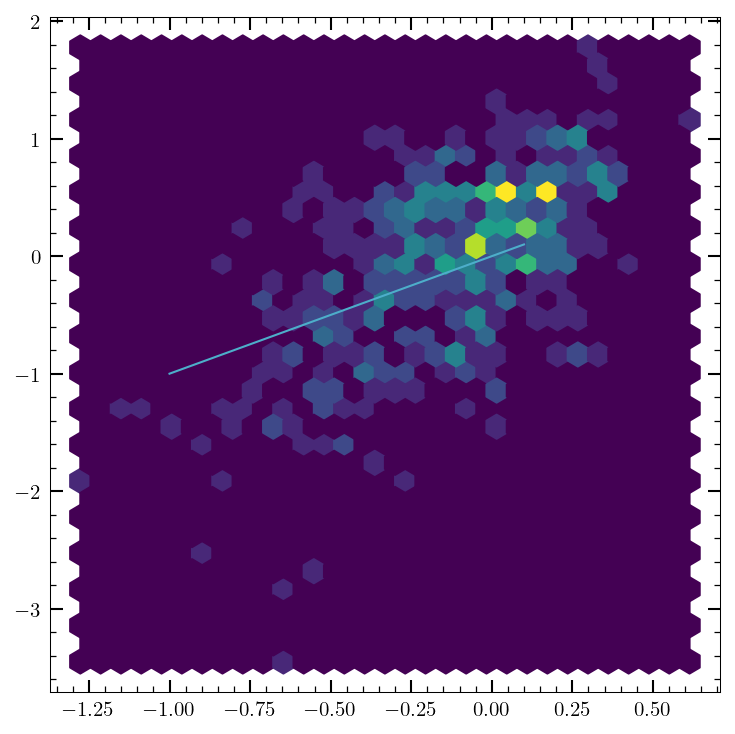

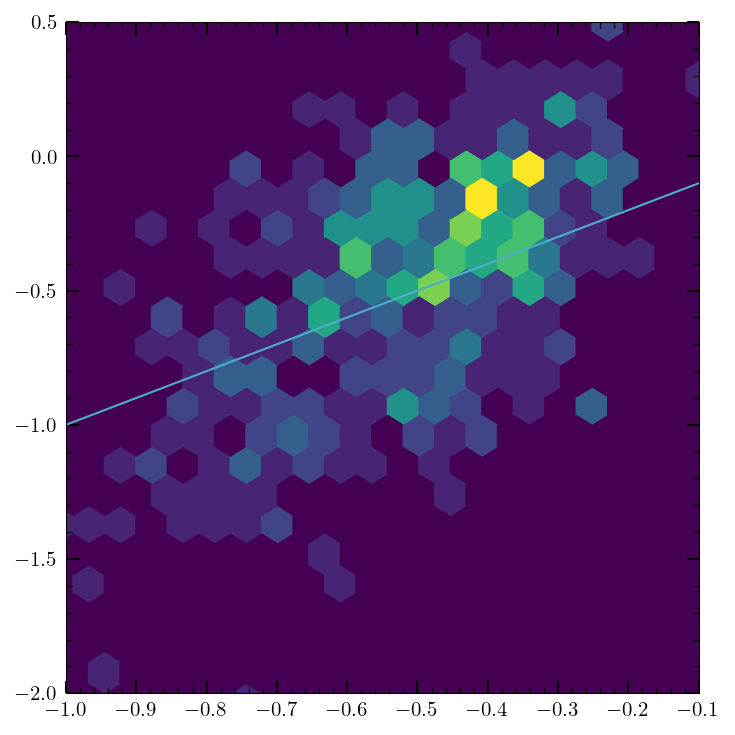

In [69]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:
        #print(data)
        #print(data.shape)
        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        #print(output.detach().numpy())
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])
#axes.set(xlim=(-0.645, -0.455), ylim=(-2, 0.5))

fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=25)
plt.plot([-1.5, 0.1], [-1.5, .1])
axes.set(xlim=(-1, -0.1), ylim=(-2, 0.5), xlabel='Predicted ')

[(-1.25, -0.15),
 (-2.0, 0.5),
 Text(0.5, 0, 'Predicted  log SFR'),
 Text(0, 0.5, 'GSWLC log SFR')]

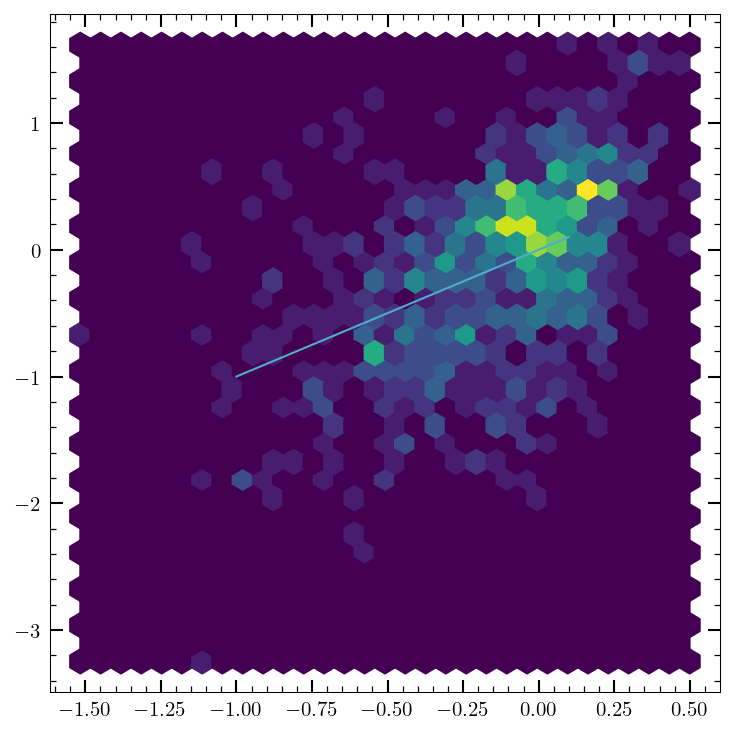

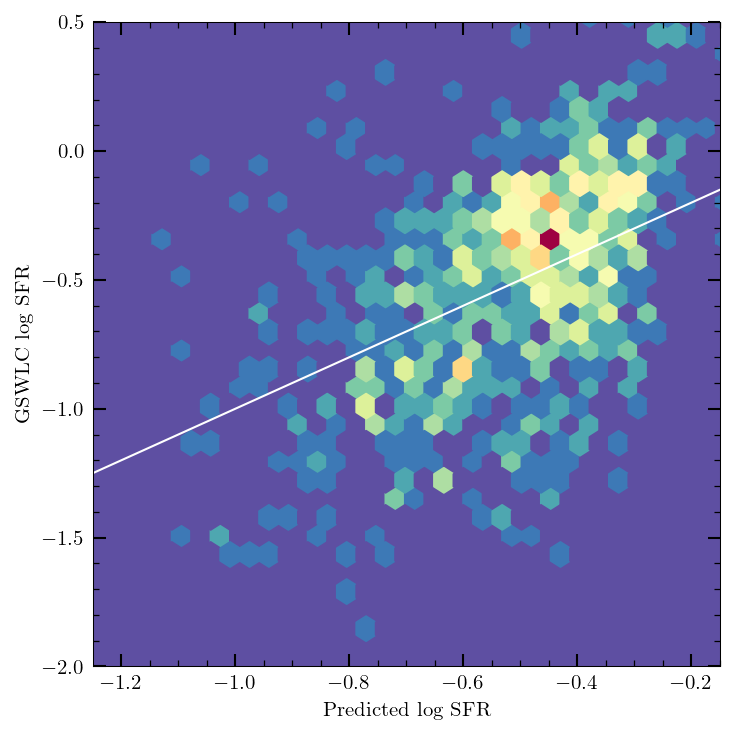

In [81]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in train_loader:
        #print(data)
        #print(data.shape)
        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        #print(output.detach().numpy())
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])
#axes.set(xlim=(-0.645, -0.455), ylim=(-2, 0.5))

fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(xlim=(-1.25, -0.15), ylim=(-2, 0.5), xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

[(-1.25, -0.15),
 (-2.0, 0.5),
 Text(0.5, 0, 'Predicted  log SFR'),
 Text(0, 0.5, 'GSWLC log SFR')]

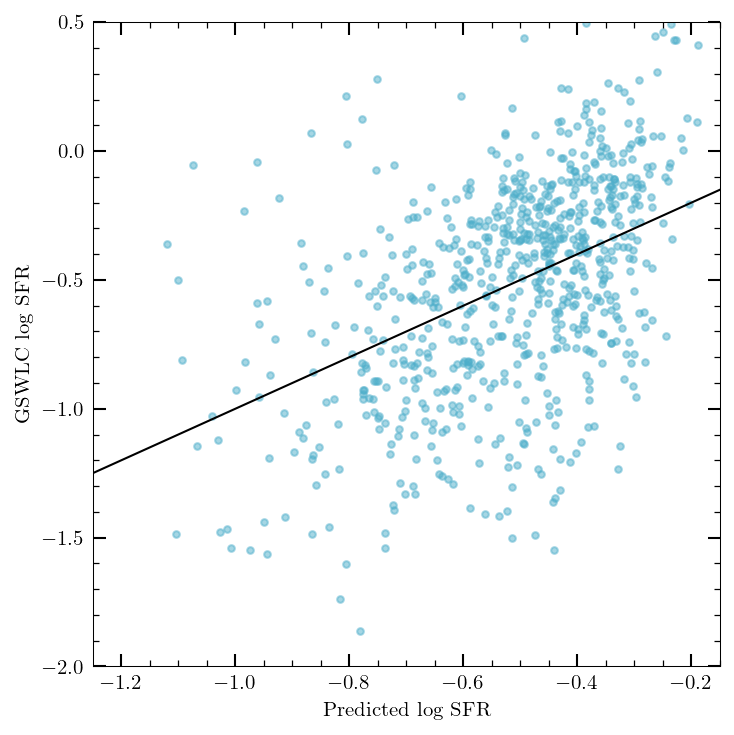

In [78]:

fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.scatter( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), s=10, alpha=0.5)
plt.plot([-1.5, 0.1], [-1.5, .1], c='k')
axes.set(xlim=(-1.25, -0.15), ylim=(-2, 0.5), xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

In [83]:
data_length = len(cleaned_photodf_nohalpha)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = preprocessing.RobustScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = preprocessing.RobustScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.0001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

750
number of epochs 5000
loss 0.519659698009491
 EPOCH 0. Train accuracy: 0.2853. Test accuracy: 0.2625
loss 0.5196143388748169
loss 0.5195695757865906
loss 0.5195254683494568
loss 0.5194818377494812
loss 0.5194388628005981
loss 0.5193964242935181
loss 0.5193546414375305
loss 0.5193133354187012
loss 0.5192726254463196
loss 0.519232451915741
 EPOCH 10. Train accuracy: 0.2867. Test accuracy: 0.26
loss 0.5191928744316101
loss 0.5191537737846375
loss 0.5191152691841125
loss 0.5190772414207458
loss 0.5190397500991821
loss 0.5190028548240662
loss 0.5189663767814636
loss 0.5189304947853088
loss 0.5188950896263123
loss 0.5188601016998291
 EPOCH 20. Train accuracy: 0.2893. Test accuracy: 0.2575
loss 0.5188256502151489
loss 0.518791675567627
loss 0.5187581777572632
loss 0.5187252163887024
loss 0.5186927318572998
loss 0.5186606049537659
loss 0.5186290144920349
loss 0.5185977816581726
loss 0.5185670256614685
loss 0.5185367465019226
 EPOCH 30. Train accuracy: 0.2867. Test accuracy: 0.2575
loss 0.5

loss 0.5173935890197754
loss 0.5173969864845276
loss 0.5174002647399902
 EPOCH 280. Train accuracy: 0.2573. Test accuracy: 0.23
loss 0.5174036622047424
loss 0.5174070000648499
loss 0.5174103379249573
loss 0.5174137353897095
loss 0.5174171328544617
loss 0.5174204111099243
loss 0.5174237489700317
loss 0.5174270868301392
loss 0.5174303650856018
loss 0.5174337029457092
 EPOCH 290. Train accuracy: 0.2547. Test accuracy: 0.2275
loss 0.5174369812011719
loss 0.5174401998519897
loss 0.5174434781074524
loss 0.5174466371536255
loss 0.5174498558044434
loss 0.5174530148506165
loss 0.5174562335014343
loss 0.5174593925476074
loss 0.5174625515937805
loss 0.5174657106399536
 EPOCH 300. Train accuracy: 0.2533. Test accuracy: 0.2275
loss 0.5174689292907715
loss 0.5174720287322998
loss 0.5174751281738281
loss 0.5174782872200012
loss 0.5174813866615295
loss 0.5174845457077026
loss 0.5174877047538757
loss 0.5174906849861145
loss 0.5174938440322876
loss 0.5174969434738159
 EPOCH 310. Train accuracy: 0.2547. 

loss 0.5175083875656128
loss 0.5175049901008606
loss 0.5175016522407532
loss 0.5174983739852905
loss 0.5174950361251831
loss 0.5174915790557861
loss 0.5174882411956787
loss 0.5174848437309265
loss 0.5174813270568848
 EPOCH 570. Train accuracy: 0.2533. Test accuracy: 0.23
loss 0.517477810382843
loss 0.517474353313446
loss 0.5174707770347595
loss 0.517467200756073
loss 0.5174636244773865
loss 0.5174600481987
loss 0.5174564123153687
loss 0.5174527764320374
loss 0.5174490213394165
loss 0.5174453854560852
 EPOCH 580. Train accuracy: 0.2533. Test accuracy: 0.23
loss 0.5174416303634644
loss 0.5174379348754883
loss 0.5174340605735779
loss 0.517430305480957
loss 0.5174265503883362
loss 0.5174226760864258
loss 0.5174187421798706
loss 0.5174148678779602
loss 0.5174109935760498
loss 0.5174071192741394
 EPOCH 590. Train accuracy: 0.2533. Test accuracy: 0.23
loss 0.5174031257629395
loss 0.5173991322517395
loss 0.5173951983451843
loss 0.5173912048339844
loss 0.5173871517181396
loss 0.5173829793930054

loss 0.5157426595687866
loss 0.5157339572906494
loss 0.515725314617157
loss 0.5157164931297302
loss 0.5157077312469482
loss 0.5156989097595215
loss 0.51569002866745
loss 0.5156812071800232
loss 0.5156723856925964
 EPOCH 850. Train accuracy: 0.248. Test accuracy: 0.225
loss 0.5156634449958801
loss 0.5156545639038086
loss 0.5156457424163818
loss 0.5156368017196655
loss 0.5156278610229492
loss 0.5156189799308777
loss 0.5156099796295166
loss 0.5156009793281555
loss 0.5155919790267944
loss 0.5155829787254333
 EPOCH 860. Train accuracy: 0.248. Test accuracy: 0.225
loss 0.5155739784240723
loss 0.5155648589134216
loss 0.5155558586120605
loss 0.5155467391014099
loss 0.5155376195907593
loss 0.5155285000801086
loss 0.5155193209648132
loss 0.515510082244873
loss 0.5155009627342224
loss 0.5154917240142822
 EPOCH 870. Train accuracy: 0.248. Test accuracy: 0.225
loss 0.515482485294342
loss 0.5154731869697571
loss 0.5154640078544617
loss 0.5154548287391663
loss 0.5154455304145813
loss 0.51543623208999

loss 0.5124480724334717
loss 0.5124341249465942
loss 0.5124201774597168
loss 0.5124062299728394
loss 0.5123922824859619
loss 0.5123783349990845
loss 0.512364387512207
loss 0.5123504400253296
loss 0.5123364329338074
 EPOCH 1130. Train accuracy: 0.2493. Test accuracy: 0.23
loss 0.5123223066329956
loss 0.5123082399368286
loss 0.5122941732406616
loss 0.5122801065444946
loss 0.5122660994529724
loss 0.5122519731521606
loss 0.5122379064559937
loss 0.5122238397598267
loss 0.5122097730636597
loss 0.5121956467628479
 EPOCH 1140. Train accuracy: 0.2493. Test accuracy: 0.23
loss 0.5121815204620361
loss 0.5121673345565796
loss 0.5121532082557678
loss 0.512139081954956
loss 0.5121249556541443
loss 0.5121107697486877
loss 0.512096643447876
loss 0.5120824575424194
loss 0.5120681524276733
loss 0.5120539665222168
 EPOCH 1150. Train accuracy: 0.2493. Test accuracy: 0.23
loss 0.5120397210121155
loss 0.5120254158973694
loss 0.5120112895965576
loss 0.511996865272522
loss 0.5119826793670654
loss 0.5119684934

 EPOCH 1400. Train accuracy: 0.2507. Test accuracy: 0.23
loss 0.5083089470863342
loss 0.508293092250824
loss 0.5082772374153137
loss 0.5082613229751587
loss 0.5082454085350037
loss 0.5082294940948486
loss 0.5082135796546936
loss 0.5081976652145386
loss 0.5081816911697388
loss 0.508165717124939
 EPOCH 1410. Train accuracy: 0.2507. Test accuracy: 0.23
loss 0.5081498622894287
loss 0.5081339478492737
loss 0.5081179141998291
loss 0.5081019997596741
loss 0.5080861449241638
loss 0.508070170879364
loss 0.5080541372299194
loss 0.5080382823944092
loss 0.508022129535675
loss 0.5080061554908752
 EPOCH 1420. Train accuracy: 0.2507. Test accuracy: 0.23
loss 0.5079902410507202
loss 0.5079742074012756
loss 0.507958173751831
loss 0.5079421401023865
loss 0.5079261660575867
loss 0.5079101324081421
loss 0.5078941583633423
loss 0.5078780055046082
loss 0.5078619718551636
loss 0.5078458786010742
 EPOCH 1430. Train accuracy: 0.2507. Test accuracy: 0.23
loss 0.5078297257423401
loss 0.5078136324882507
loss 0.50

loss 0.5036824345588684
loss 0.5036642551422119
loss 0.5036461353302002
 EPOCH 1680. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.5036278963088989
loss 0.5036097764968872
loss 0.5035915970802307
loss 0.5035734176635742
loss 0.5035551190376282
loss 0.5035369396209717
loss 0.5035185813903809
loss 0.5035002827644348
loss 0.503481924533844
loss 0.503463625907898
 EPOCH 1690. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.5034452676773071
loss 0.5034269094467163
loss 0.5034085512161255
loss 0.5033901929855347
loss 0.5033718347549438
loss 0.5033533573150635
loss 0.5033350586891174
loss 0.5033166408538818
loss 0.5032981038093567
loss 0.5032797455787659
 EPOCH 1700. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.5032613277435303
loss 0.5032427906990051
loss 0.5032243132591248
loss 0.5032057762145996
loss 0.503187358379364
loss 0.5031687617301941
loss 0.5031502842903137
loss 0.5031317472457886
loss 0.5031131505966187
loss 0.5030946135520935
 EPOCH 1710. Train accuracy: 0.254

loss 0.49820446968078613
loss 0.4981839060783386
loss 0.4981631934642792
 EPOCH 1960. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.49814262986183167
loss 0.49812185764312744
loss 0.49810126423835754
loss 0.49808061122894287
loss 0.4980599582195282
loss 0.49803927540779114
loss 0.49801862239837646
loss 0.49799787998199463
loss 0.4979771673679352
loss 0.4979565143585205
 EPOCH 1970. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.4979357421398163
loss 0.4979150891304016
loss 0.4978942573070526
loss 0.4978734850883484
loss 0.4978526830673218
loss 0.49783188104629517
loss 0.497810959815979
loss 0.4977901875972748
loss 0.4977692663669586
loss 0.4977482855319977
 EPOCH 1980. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.4977273643016815
loss 0.4977063834667206
loss 0.4976852834224701
loss 0.497664213180542
loss 0.49764305353164673
loss 0.49762192368507385
loss 0.497600793838501
loss 0.4975796639919281
loss 0.49755847454071045
loss 0.4975373148918152
 EPOCH 1990. Train acc

loss 0.49197301268577576
loss 0.4919486939907074
loss 0.4919242858886719
loss 0.4918997585773468
loss 0.4918752908706665
loss 0.49185073375701904
loss 0.4918261468410492
 EPOCH 2240. Train accuracy: 0.2573. Test accuracy: 0.23
loss 0.49180155992507935
loss 0.4917770326137543
loss 0.4917524456977844
loss 0.4917278289794922
loss 0.49170318245887756
loss 0.4916785955429077
loss 0.4916538894176483
loss 0.4916291832923889
loss 0.49160462617874146
loss 0.4915798306465149
 EPOCH 2250. Train accuracy: 0.2573. Test accuracy: 0.23
loss 0.4915551245212555
loss 0.4915304481983185
loss 0.4915057122707367
loss 0.4914809763431549
loss 0.49145618081092834
loss 0.49143141508102417
loss 0.4914066195487976
loss 0.49138182401657104
loss 0.4913569986820221
loss 0.49133214354515076
 EPOCH 2260. Train accuracy: 0.2573. Test accuracy: 0.23
loss 0.4913072884082794
loss 0.4912824332714081
loss 0.4912573993206024
loss 0.49123242497444153
loss 0.49120742082595825
loss 0.491182416677475
loss 0.4911574125289917
los

loss 0.484624981880188
loss 0.4845964014530182
loss 0.4845677614212036
loss 0.4845391511917114
loss 0.4845105707645416
loss 0.4844818413257599
loss 0.4844532310962677
loss 0.48442450165748596
loss 0.484395831823349
loss 0.48436710238456726
 EPOCH 2520. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.4843383729457855
loss 0.4843095541000366
loss 0.4842807352542877
loss 0.4842519760131836
loss 0.4842230975627899
loss 0.4841943085193634
loss 0.48416537046432495
loss 0.4841364920139313
loss 0.4841075837612152
loss 0.484078586101532
 EPOCH 2530. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.484049528837204
loss 0.48402053117752075
loss 0.48399144411087036
loss 0.48396244645118713
loss 0.48393329977989197
loss 0.4839041829109192
loss 0.483875036239624
loss 0.48384588956832886
loss 0.4838167428970337
loss 0.4837876260280609
 EPOCH 2540. Train accuracy: 0.2547. Test accuracy: 0.2325
loss 0.48375841975212097
loss 0.48372921347618103
loss 0.4837000370025635
loss 0.48367077112197876
l

loss 0.47613611817359924
loss 0.4761028289794922
loss 0.4760694205760956
loss 0.47603604197502136
loss 0.47600260376930237
 EPOCH 2790. Train accuracy: 0.2533. Test accuracy: 0.2325
loss 0.47596922516822815
loss 0.47593581676483154
loss 0.4759023189544678
loss 0.47586891055107117
loss 0.4758354425430298
loss 0.4758020043373108
loss 0.47576844692230225
loss 0.4757349491119385
loss 0.4757014513015747
loss 0.4756678640842438
 EPOCH 2800. Train accuracy: 0.2533. Test accuracy: 0.2325
loss 0.47563427686691284
loss 0.4756007492542267
loss 0.47556716203689575
loss 0.4755335748195648
loss 0.4754999876022339
loss 0.47546637058258057
loss 0.47543278336524963
loss 0.4753991365432739
loss 0.4753654897212982
loss 0.4753318130970001
 EPOCH 2810. Train accuracy: 0.2533. Test accuracy: 0.2325
loss 0.47529807686805725
loss 0.47526443004608154
loss 0.47523075342178345
loss 0.4751969873905182
loss 0.47516322135925293
loss 0.4751294255256653
loss 0.47509562969207764
loss 0.47506183385849
loss 0.4750280082

loss 0.4663853049278259
loss 0.4663468897342682
 EPOCH 3060. Train accuracy: 0.2533. Test accuracy: 0.2325
loss 0.46630844473838806
loss 0.46626999974250793
loss 0.4662316143512726
loss 0.4661930501461029
loss 0.466154545545578
loss 0.46611592173576355
loss 0.4660772979259491
loss 0.46603867411613464
loss 0.465999960899353
loss 0.4659613072872162
 EPOCH 3070. Train accuracy: 0.252. Test accuracy: 0.2325
loss 0.46592262387275696
loss 0.46588394045829773
loss 0.4658451974391937
loss 0.46580642461776733
loss 0.46576762199401855
loss 0.4657287895679474
loss 0.46568992733955383
loss 0.46565112471580505
loss 0.4656122922897339
loss 0.4655734896659851
 EPOCH 3080. Train accuracy: 0.252. Test accuracy: 0.2325
loss 0.46553462743759155
loss 0.4654957950115204
loss 0.4654569625854492
loss 0.4654179811477661
loss 0.46537911891937256
loss 0.46534010767936707
loss 0.46530112624168396
loss 0.4652619957923889
loss 0.46522286534309387
loss 0.4651837944984436
 EPOCH 3090. Train accuracy: 0.2507. Test ac

loss 0.4552620053291321
loss 0.45521900057792664
loss 0.45517608523368835
loss 0.4551331400871277
loss 0.45509016513824463
loss 0.4550471901893616
loss 0.45500412583351135
loss 0.4549611210823059
loss 0.45491814613342285
 EPOCH 3340. Train accuracy: 0.26. Test accuracy: 0.2325
loss 0.454875111579895
loss 0.4548319876194
loss 0.4547889828681946
loss 0.4547458589076996
loss 0.4547026753425598
loss 0.4546595811843872
loss 0.45461639761924744
loss 0.45457327365875244
loss 0.4545300304889679
loss 0.4544868469238281
 EPOCH 3350. Train accuracy: 0.26. Test accuracy: 0.2325
loss 0.4544435441493988
loss 0.45440036058425903
loss 0.4543570578098297
loss 0.454313725233078
loss 0.4542703926563263
loss 0.4542270004749298
loss 0.4541836977005005
loss 0.45414048433303833
loss 0.45409730076789856
loss 0.4540540277957916
 EPOCH 3360. Train accuracy: 0.26. Test accuracy: 0.2325
loss 0.45401084423065186
loss 0.45396748185157776
loss 0.4539242088794708
loss 0.4538809061050415
loss 0.4538375437259674
loss 0

 EPOCH 3610. Train accuracy: 0.2667. Test accuracy: 0.2275
loss 0.44256725907325745
loss 0.44251957535743713
loss 0.4424716830253601
loss 0.442423939704895
loss 0.442376047372818
loss 0.44232821464538574
loss 0.4422803223133087
loss 0.4422324001789093
loss 0.4421844482421875
loss 0.4421364963054657
 EPOCH 3620. Train accuracy: 0.268. Test accuracy: 0.2275
loss 0.4420885443687439
loss 0.4420406222343445
loss 0.4419926702976227
loss 0.4419447183609009
loss 0.4418967068195343
loss 0.4418487250804901
loss 0.44180068373680115
loss 0.44175270199775696
loss 0.441704660654068
loss 0.44165661931037903
 EPOCH 3630. Train accuracy: 0.268. Test accuracy: 0.2275
loss 0.44160860776901245
loss 0.4415605664253235
loss 0.44151249527931213
loss 0.44146445393562317
loss 0.44141635298728943
loss 0.4413682520389557
loss 0.44132012128829956
loss 0.4412720501422882
loss 0.4412239193916321
loss 0.44117581844329834
 EPOCH 3640. Train accuracy: 0.268. Test accuracy: 0.225
loss 0.44112759828567505
loss 0.4410794

loss 0.4288490414619446
loss 0.42879775166511536
loss 0.4287465214729309
loss 0.4286951720714569
 EPOCH 3890. Train accuracy: 0.2693. Test accuracy: 0.2275
loss 0.4286438226699829
loss 0.4285925328731537
loss 0.4285410940647125
loss 0.4284897744655609
loss 0.42843836545944214
loss 0.42838698625564575
loss 0.428335577249527
loss 0.4282841086387634
loss 0.4282326400279999
loss 0.4281812310218811
 EPOCH 3900. Train accuracy: 0.2707. Test accuracy: 0.2275
loss 0.42812979221343994
loss 0.428078293800354
loss 0.42802679538726807
loss 0.42797529697418213
loss 0.42792370915412903
loss 0.4278721511363983
loss 0.4278205931186676
loss 0.4277689754962921
loss 0.4277173578739166
loss 0.42766574025154114
 EPOCH 3910. Train accuracy: 0.2707. Test accuracy: 0.2275
loss 0.42761412262916565
loss 0.4275624454021454
loss 0.4275107681751251
loss 0.4274590313434601
loss 0.4274073839187622
loss 0.4273555874824524
loss 0.42730388045310974
loss 0.4272520840167999
loss 0.4272003471851349
loss 0.4271485805511474

loss 0.4140855073928833
loss 0.4140303432941437
loss 0.41397514939308167
loss 0.41391998529434204
loss 0.41386470198631287
loss 0.41380947828292847
loss 0.41375428438186646
loss 0.41369903087615967
 EPOCH 4170. Train accuracy: 0.2707. Test accuracy: 0.23
loss 0.4136437475681305
loss 0.4135885238647461
loss 0.4135332405567169
loss 0.41347819566726685
loss 0.4134231209754944
loss 0.41336798667907715
loss 0.4133128821849823
loss 0.4132576882839203
loss 0.4132026433944702
loss 0.4131474196910858
 EPOCH 4180. Train accuracy: 0.2707. Test accuracy: 0.23
loss 0.4130922555923462
loss 0.41303712129592896
loss 0.41298195719718933
loss 0.4129268527030945
loss 0.41287171840667725
loss 0.4128165543079376
loss 0.4127614498138428
loss 0.41270625591278076
loss 0.41265106201171875
loss 0.4125959277153015
 EPOCH 4190. Train accuracy: 0.2707. Test accuracy: 0.23
loss 0.41254082322120667
loss 0.41248565912246704
loss 0.4124304950237274
loss 0.4123753309249878
loss 0.41232016682624817
loss 0.41226500272750

loss 0.39882904291152954
 EPOCH 4440. Train accuracy: 0.284. Test accuracy: 0.235
loss 0.39877378940582275
loss 0.39871856570243835
loss 0.3986632823944092
loss 0.3986080288887024
loss 0.39855265617370605
loss 0.39849740266799927
loss 0.39844217896461487
loss 0.39838698506355286
loss 0.39833182096481323
loss 0.398276686668396
 EPOCH 4450. Train accuracy: 0.2853. Test accuracy: 0.235
loss 0.3982214629650116
loss 0.3981662690639496
loss 0.3981110453605652
loss 0.3980558514595032
loss 0.398000568151474
loss 0.397945374250412
loss 0.3978900909423828
loss 0.3978349268436432
loss 0.3977797031402588
loss 0.3977245092391968
 EPOCH 4460. Train accuracy: 0.284. Test accuracy: 0.24
loss 0.3976692855358124
loss 0.39761409163475037
loss 0.39755889773368835
loss 0.3975037634372711
loss 0.3974486291408539
loss 0.39739352464675903
loss 0.39733847975730896
loss 0.3972834050655365
loss 0.39722833037376404
loss 0.3971732258796692
 EPOCH 4470. Train accuracy: 0.2827. Test accuracy: 0.2375
loss 0.397118270

loss 0.38394495844841003
loss 0.3838922381401062
loss 0.38383960723876953
loss 0.38378697633743286
loss 0.3837342858314514
loss 0.38368159532546997
 EPOCH 4720. Train accuracy: 0.2787. Test accuracy: 0.2525
loss 0.38362908363342285
loss 0.3835764229297638
loss 0.38352376222610474
loss 0.3834711015224457
loss 0.3834184408187866
loss 0.38336578011512756
loss 0.3833131492137909
loss 0.38326048851013184
loss 0.383207768201828
loss 0.38315510749816895
 EPOCH 4730. Train accuracy: 0.2787. Test accuracy: 0.2525
loss 0.3831024467945099
loss 0.38304969668388367
loss 0.3829970061779022
loss 0.3829442262649536
loss 0.38289153575897217
loss 0.3828388452529907
loss 0.38278618454933167
loss 0.38273346424102783
loss 0.382680743932724
loss 0.38262808322906494
 EPOCH 4740. Train accuracy: 0.2787. Test accuracy: 0.2525
loss 0.38257530331611633
loss 0.38252267241477966
loss 0.3824700117111206
loss 0.38241732120513916
loss 0.38236480951309204
loss 0.3823123276233673
loss 0.3822597861289978
loss 0.38220733

loss 0.36979398131370544
loss 0.3697434961795807
 EPOCH 4990. Train accuracy: 0.2773. Test accuracy: 0.26
loss 0.3696931004524231
loss 0.3696426451206207
loss 0.3695921301841736
loss 0.369541734457016
loss 0.36949121952056885
loss 0.3694407343864441
loss 0.3693903088569641
loss 0.36933985352516174
loss 0.36928942799568176


[(-1.25, -0.15),
 (-2.0, 0.5),
 Text(0.5, 0, 'Predicted  log SFR'),
 Text(0, 0.5, 'GSWLC log SFR')]

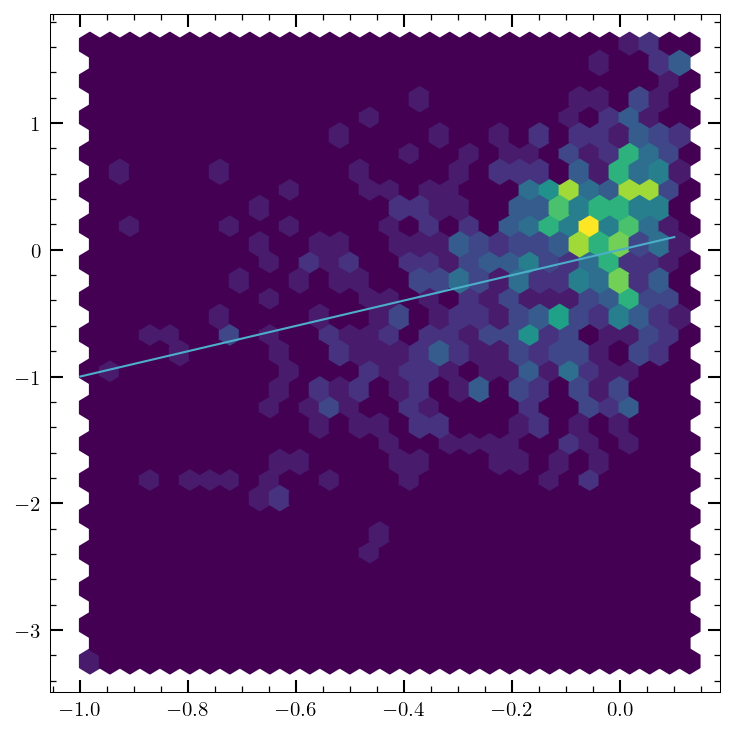

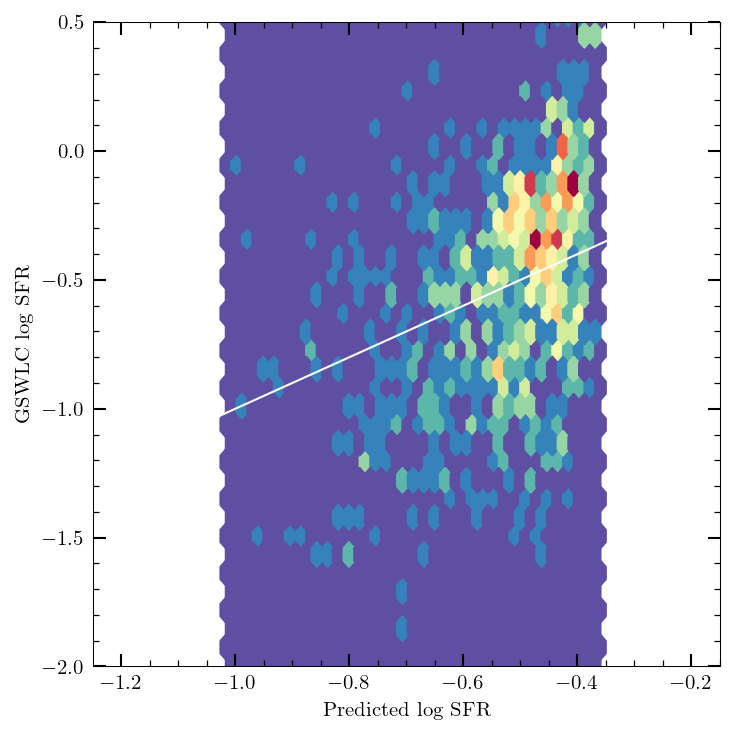

In [84]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in train_loader:
        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])

fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(xlim=(-1.25, -0.15), ylim=(-2, 0.5), xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

In [36]:
data_length = len(cleaned_photodf)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = preprocessing.RobustScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = preprocessing.RobustScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

900
loss 0.3882949948310852
 EPOCH 0. Train accuracy: 0.2433. Test accuracy: 0.2167
loss 0.3878239691257477
loss 0.3873778283596039
loss 0.38695529103279114
loss 0.3865530490875244
loss 0.38616615533828735
loss 0.3857983350753784
loss 0.38544923067092896
loss 0.38511598110198975
loss 0.38479891419410706
loss 0.38449639081954956
loss 0.38420799374580383
loss 0.38393324613571167
loss 0.38366931676864624
loss 0.3834134638309479
loss 0.38316649198532104
loss 0.3829280138015747
loss 0.382696270942688
loss 0.382468581199646
loss 0.3822438418865204
loss 0.38202452659606934
loss 0.3818120062351227
loss 0.38160568475723267
loss 0.3814084529876709
loss 0.3812183141708374
loss 0.3810335397720337
loss 0.3808528780937195
loss 0.38067591190338135
loss 0.38050177693367004
loss 0.38032981753349304
loss 0.3801605999469757
loss 0.379995197057724
loss 0.3798348307609558
loss 0.379679411649704
loss 0.3795301914215088
loss 0.3793834447860718
loss 0.3792382776737213
loss 0.37909314036369324
loss 0.378950834

loss 0.31446775794029236
loss 0.31420719623565674
loss 0.31394511461257935
loss 0.3136819005012512
loss 0.3134208023548126
loss 0.3131605088710785
loss 0.3129017949104309
loss 0.3126436471939087
loss 0.31238746643066406
loss 0.312132865190506
loss 0.3118788003921509
loss 0.31162697076797485
loss 0.3113757371902466
loss 0.3111264109611511
loss 0.31087639927864075
loss 0.3106244206428528
loss 0.3103735148906708
loss 0.3101242184638977
loss 0.3098759651184082
loss 0.30962949991226196
loss 0.30938470363616943
loss 0.3091427981853485
loss 0.30890190601348877
loss 0.3086625039577484
loss 0.308424174785614
loss 0.30818864703178406
loss 0.3079531490802765
loss 0.30771690607070923
loss 0.30748283863067627
loss 0.3072497844696045
loss 0.3070176839828491
 EPOCH 350. Train accuracy: 0.2822. Test accuracy: 0.2367
loss 0.30678731203079224
loss 0.30655592679977417
loss 0.30632519721984863
loss 0.3060950040817261
loss 0.30586671829223633
loss 0.30563926696777344
loss 0.3054104745388031
loss 0.30518364

loss 0.2844785153865814
loss 0.28445348143577576
loss 0.28442665934562683
loss 0.2844094932079315
loss 0.28438082337379456
loss 0.2843529284000397
loss 0.28433355689048767
loss 0.28430283069610596
loss 0.2842736542224884
 EPOCH 650. Train accuracy: 0.3067. Test accuracy: 0.3133
loss 0.2842482328414917
loss 0.2842210531234741
loss 0.2841905653476715
loss 0.28416985273361206
loss 0.2841404974460602
loss 0.2841093838214874
loss 0.2840782403945923
loss 0.28404492139816284
loss 0.2840197682380676
loss 0.28398585319519043
loss 0.28394952416419983
loss 0.2839169502258301
loss 0.28387874364852905
loss 0.28383639454841614
loss 0.28380653262138367
loss 0.283765971660614
loss 0.28372496366500854
loss 0.283692330121994
loss 0.28364962339401245
loss 0.28361451625823975
loss 0.2835693657398224
loss 0.2835344076156616
loss 0.2834903597831726
loss 0.28344789147377014
loss 0.28341051936149597
loss 0.2833613157272339
loss 0.28332120180130005
loss 0.28327617049217224
loss 0.2832350432872772
loss 0.283189

loss 0.27216923236846924
loss 0.27212581038475037
loss 0.2720787823200226
loss 0.2720310091972351
loss 0.27198365330696106
loss 0.2719360291957855
loss 0.27188923954963684
loss 0.27183619141578674
loss 0.27178817987442017
loss 0.27175062894821167
loss 0.2717013657093048
loss 0.2716537415981293
loss 0.27160149812698364
loss 0.2715522050857544
loss 0.27150189876556396
loss 0.27145445346832275
loss 0.27140823006629944
loss 0.2713641822338104
loss 0.2713077962398529
loss 0.271259605884552
loss 0.2712102234363556
loss 0.27116894721984863
loss 0.27111586928367615
loss 0.27106791734695435
loss 0.2710168957710266
loss 0.2709709107875824
loss 0.2709183394908905
loss 0.2708682715892792
loss 0.27081841230392456
loss 0.2707681953907013
loss 0.27071622014045715
loss 0.27067387104034424
loss 0.27062463760375977
loss 0.2705731987953186
loss 0.27052149176597595
loss 0.270470529794693
loss 0.2704262435436249


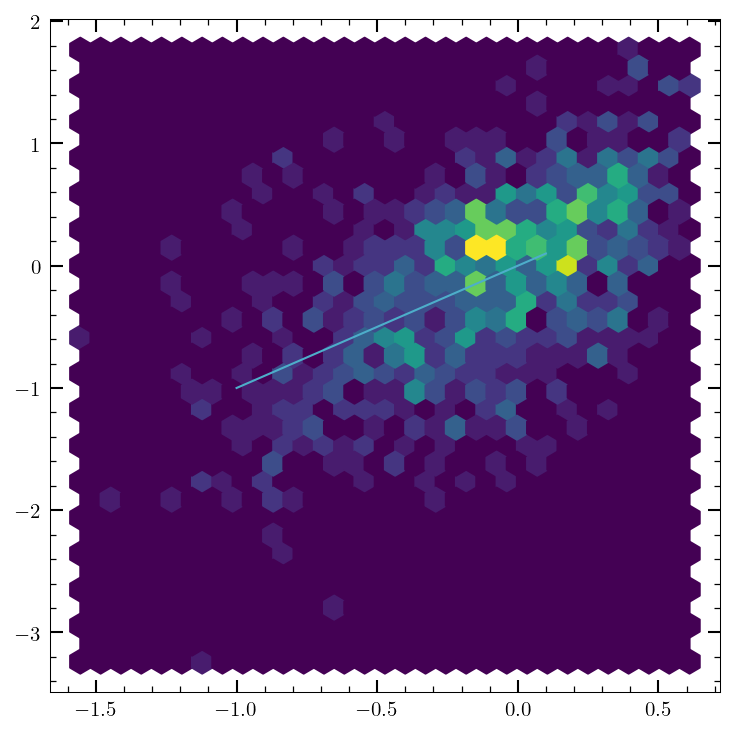

In [37]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in train_loader:

        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])

[(-2.0, 0.5),
 (-2.0, 0.5),
 Text(0.5, 0, 'Predicted  log SFR'),
 Text(0, 0.5, 'GSWLC log SFR')]

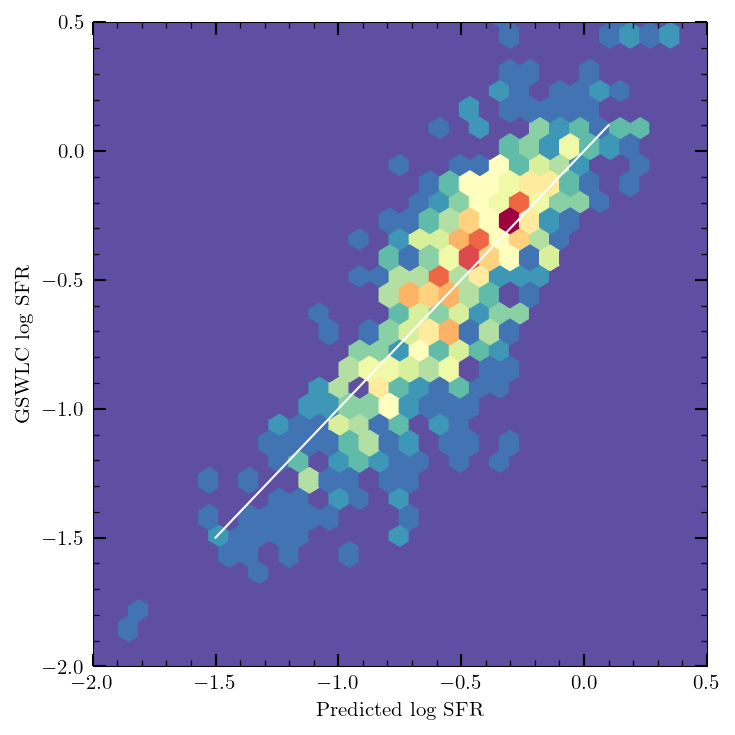

In [89]:
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(xlim=(-2, 0.5), ylim=(-2, 0.5), xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

[(-2.0, 0.5),
 (-2.0, 0.5),
 Text(0.5, 0, 'Predicted  log SFR'),
 Text(0, 0.5, 'GSWLC log SFR')]

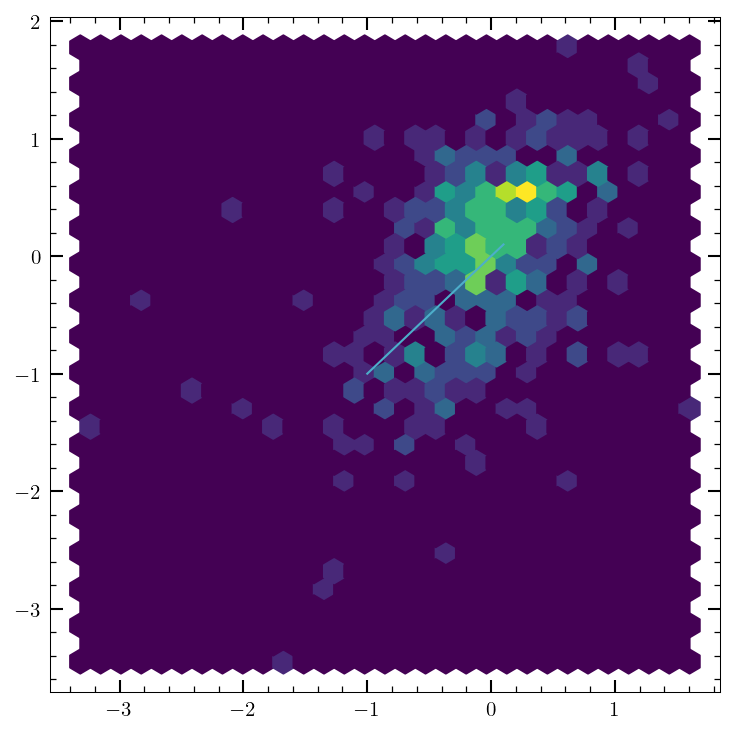

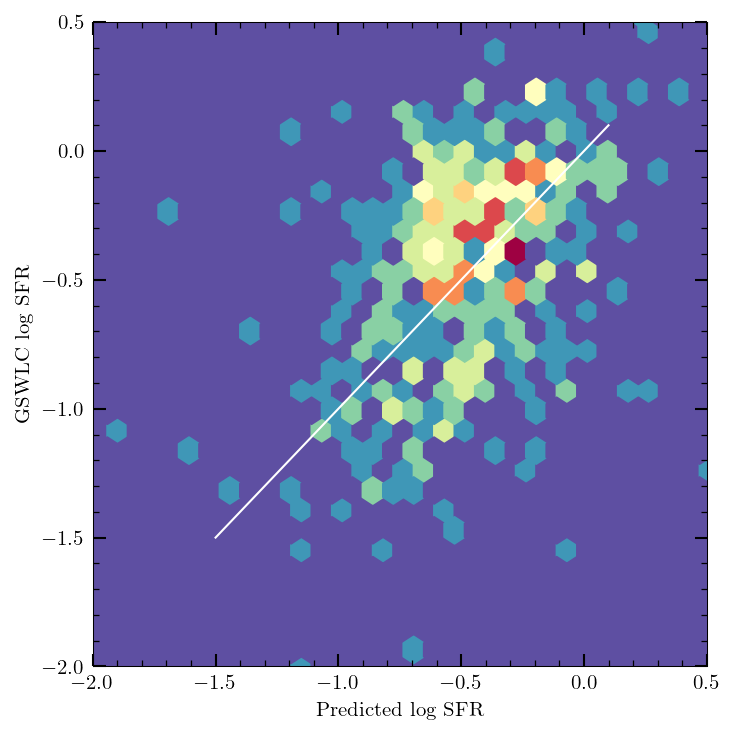

In [90]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:

        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(xlim=(-2, 0.5), ylim=(-2, 0.5), xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

[(-2.0, 0.5),
 (-2.0, 0.5),
 Text(0.5, 0, 'Predicted  log SFR'),
 Text(0, 0.5, 'GSWLC log SFR')]

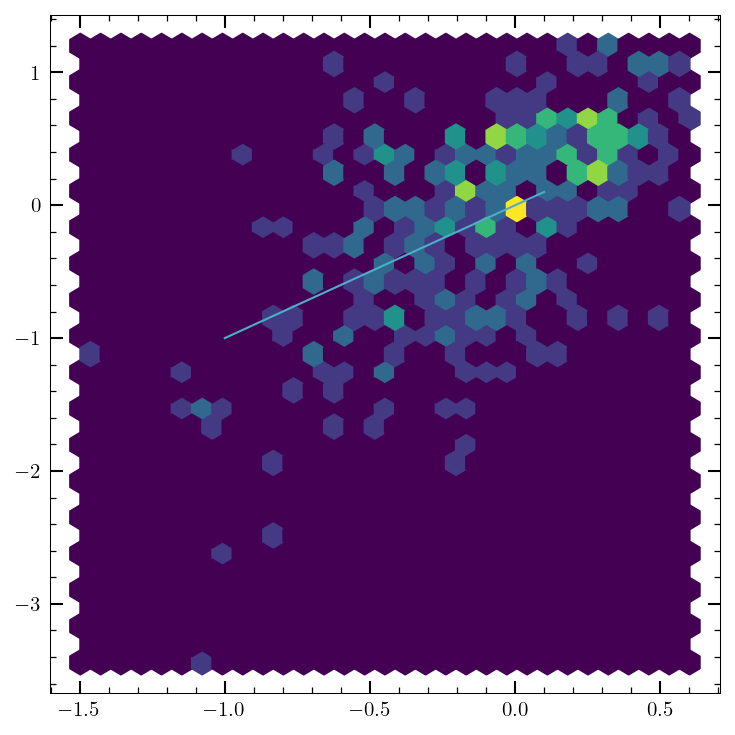

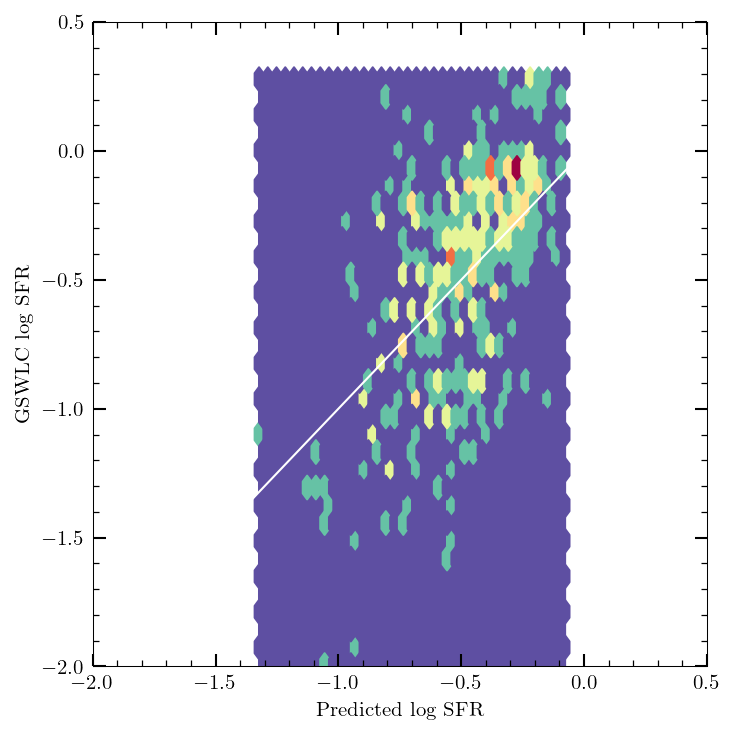

In [38]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:

        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
plt.plot([-1, 0.1], [-1, .1])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(xlim=(-2, 0.5), ylim=(-2, 0.5), xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

## Try normalizing all collumns together

In [40]:
# Calculate the size of the training/testing split of the data
data_length = len(cleaned_photodf)
train_cap = int(np.floor(0.80*data_length / 50)*50)
print(train_cap)

#------Normalize the data columns------
# define min max scaler
scaler = MinMaxScaler()
# transform data
cleaned_photodf['SFR'] = cleaned_SFR
scaled_input = scaler.fit_transform(cleaned_photodf)
cleaned_SFR = cleaned_photodf['SFR'].values
cleaned_photodf = cleaned_photodf.drop(columns=['SFR'])
scaled_truth = scaled_input[:, 17]
scaled_input = scaled_input[:, :17]

950


In [41]:
train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

/opt/anaconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss 0.2779216468334198
 EPOCH 0. Train accuracy: 0.0474. Test accuracy: 0.048
loss 0.2501913011074066
loss 0.2254105657339096
loss 0.2032366245985031
loss 0.1833944022655487
loss 0.16563041508197784
loss 0.14971823990345
loss 0.13545642793178558
loss 0.12268006801605225
loss 0.11123861372470856
loss 0.10099401324987411
loss 0.091824471950531
loss 0.08362055569887161
loss 0.07628584653139114
loss 0.06972996890544891
loss 0.06387458741664886
loss 0.05864892527461052
loss 0.053985077887773514
loss 0.04982365295290947
loss 0.04611651599407196
loss 0.04281461238861084
loss 0.03987647965550423
loss 0.037264540791511536
loss 0.03494512289762497
loss 0.0328885056078434
loss 0.03106669895350933
loss 0.02945382334291935
loss 0.02802734449505806
loss 0.026766348630189896
loss 0.025652367621660233
loss 0.024668529629707336
loss 0.02379918284714222
loss 0.023031005635857582
loss 0.022352540865540504
loss 0.02175351046025753
loss 0.021224364638328552
loss 0.02075684256851673
loss 0.0203435383737087

loss 0.01706351339817047
loss 0.01706351339817047
loss 0.017063511535525322
loss 0.017063509672880173
loss 0.017063509672880173
loss 0.017063509672880173
loss 0.017063507810235023
loss 0.017063509672880173
loss 0.017063507810235023
loss 0.017063507810235023
loss 0.017063505947589874
loss 0.017063507810235023
loss 0.017063505947589874
loss 0.017063505947589874
loss 0.017063504084944725
loss 0.017063504084944725
loss 0.017063504084944725
loss 0.017063504084944725
loss 0.017063500359654427
loss 0.017063500359654427
loss 0.017063500359654427
loss 0.017063500359654427
loss 0.017063500359654427
loss 0.017063500359654427
loss 0.017063500359654427
loss 0.017063498497009277
loss 0.017063498497009277
loss 0.017063496634364128
loss 0.017063496634364128
loss 0.01706349477171898
loss 0.01706349290907383
loss 0.01706349477171898
loss 0.01706349290907383
loss 0.01706349104642868
loss 0.01706349290907383
loss 0.01706349104642868
loss 0.01706349104642868
loss 0.01706349290907383
loss 0.0170634910464286

loss 0.017063280567526817
loss 0.017063280567526817
loss 0.017063280567526817
loss 0.017063278704881668
loss 0.01706327684223652
loss 0.01706327684223652
loss 0.01706327684223652
loss 0.01706327497959137
loss 0.01706327497959137
loss 0.01706327497959137
loss 0.01706327311694622
loss 0.01706327125430107
loss 0.01706327125430107
loss 0.01706327125430107
loss 0.01706327125430107
loss 0.01706327125430107
loss 0.01706327125430107
loss 0.01706327125430107
loss 0.017063269391655922
loss 0.01706327125430107
loss 0.017063269391655922
loss 0.017063269391655922
loss 0.01706327125430107
loss 0.017063269391655922
loss 0.017063267529010773
loss 0.01706327125430107
loss 0.017063269391655922
loss 0.017063267529010773
loss 0.017063267529010773
loss 0.017063269391655922
loss 0.017063267529010773
loss 0.017063267529010773
loss 0.017063265666365623
loss 0.017063267529010773
 EPOCH 650. Train accuracy: 0.9347. Test accuracy: 0.948
loss 0.017063267529010773
loss 0.017063263803720474
loss 0.01706326566636562

loss 0.017063088715076447
loss 0.017063088715076447
loss 0.017063086852431297
loss 0.017063086852431297
loss 0.017063086852431297
loss 0.017063084989786148
loss 0.017063084989786148
loss 0.017063083127141
loss 0.017063083127141
loss 0.01706308126449585
loss 0.01706308126449585
loss 0.0170630794018507
loss 0.01706307753920555
loss 0.0170630794018507
loss 0.0170630794018507
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
 EPOCH 950. Train accuracy: 0.9347. Test accuracy: 0.948
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.017063075676560402
loss 0.017063075676560402
loss 0.017063073813915253
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.017063075676560402
loss 0.01706307753920555
loss 0.017063075676560402
loss 0.01706307753920555
loss 0.01706307753920555
loss 0.017063075676560402
loss 0.01706

In [15]:
scaled_input.shape

(1208, 18)

In [13]:
scaled_truth

array([-0.205, -1.084, -0.257, ...,  0.335, -1.308, -1.437])

In [72]:
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,halpha
0,20.630505,20.630505,20.072167,20.072167,19.592112,19.592112,22.856167,22.856167,24.027126,24.027126,0.558338,0.558338,0.480055,0.480055,1.170959,1.170959,1.323939
1,21.055134,20.527209,20.459412,19.929611,20.145202,19.625306,23.416416,22.795154,24.905366,24.351031,0.595722,0.067797,0.314210,0.304305,1.488950,1.555877,1.588927
2,21.417541,20.262839,20.548975,19.422085,19.852283,18.770072,24.532448,23.213055,26.663405,25.484405,0.868565,-0.286136,0.696693,0.652013,2.130957,2.271350,1.216455
3,20.525722,20.525722,19.407658,19.407658,18.345308,18.345308,25.205080,25.205080,26.671650,26.671650,1.118064,1.118064,1.062350,1.062350,1.466570,1.466570,0.877957
4,19.643996,19.643996,18.630520,18.630520,17.745149,17.745149,24.311589,24.311589,26.510112,26.510112,1.013476,1.013476,0.885371,0.885371,2.198523,2.198523,1.659765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,20.031116,20.031116,19.587118,19.587118,19.062373,19.062373,23.159969,23.159969,24.235471,24.235471,0.443998,0.443998,0.524745,0.524745,1.075502,1.075502,1.447731
1342,20.926629,19.828001,20.032873,18.906255,19.114810,18.008631,27.225596,25.136567,26.365950,25.355958,0.893756,-0.204872,0.918063,0.897623,-0.859646,0.219391,0.792647
1343,19.406744,19.406744,18.839096,18.839096,18.238225,18.238225,23.447150,23.447150,25.887239,25.887239,0.567648,0.567648,0.600871,0.600871,2.440089,2.440089,1.544925
1347,19.418434,20.014512,18.593787,19.215990,17.766503,18.373907,24.389183,25.201631,24.299183,24.973246,0.824647,1.420725,0.827284,0.842083,-0.090001,-0.228385,-0.294242


In [109]:
data_length = len(cleaned_photodf)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = preprocessing.RobustScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf)
# define min max scaler
scaler2 = preprocessing.RobustScaler()
scaled_truth = scaler2.fit_transform(cleaned_SFR.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=25
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

900
loss 0.4308910071849823
 EPOCH 0. Train accuracy: 0.2367. Test accuracy: 0.2167
loss 0.42906785011291504
loss 0.4274548590183258
loss 0.4260252118110657
loss 0.4247543215751648
loss 0.42362159490585327
loss 0.4226127564907074
loss 0.4217197000980377
loss 0.4209252893924713
loss 0.4202134311199188
loss 0.41957491636276245
loss 0.4190003573894501
loss 0.4184814393520355
loss 0.4180118143558502
loss 0.4175863265991211
loss 0.41720011830329895
loss 0.4168492555618286
loss 0.4165297746658325
loss 0.4162389636039734
loss 0.415973424911499
loss 0.41573065519332886
loss 0.41550880670547485
loss 0.41530632972717285
loss 0.415120393037796
loss 0.41494882106781006
loss 0.41479161381721497
loss 0.4146465063095093
loss 0.4145123362541199
loss 0.41438835859298706
loss 0.4142739474773407
loss 0.4141673743724823
loss 0.4140678644180298
loss 0.41397473216056824
loss 0.4138875901699066
loss 0.4138070046901703
loss 0.4137303829193115
loss 0.413657546043396
loss 0.41358962655067444
loss 0.413525700569

[Text(0.5, 0, 'Predicted  log SFR'), Text(0, 0.5, 'GSWLC log SFR')]

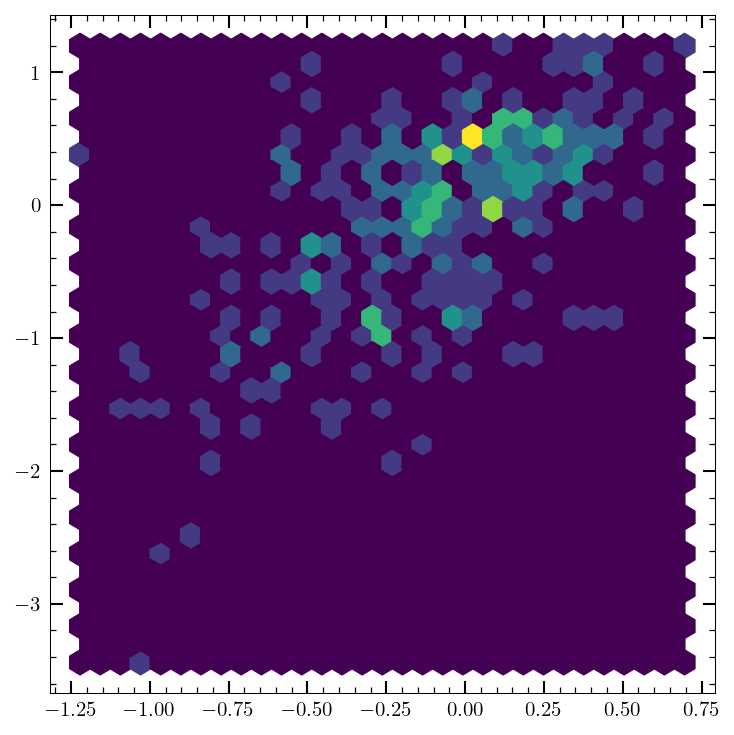

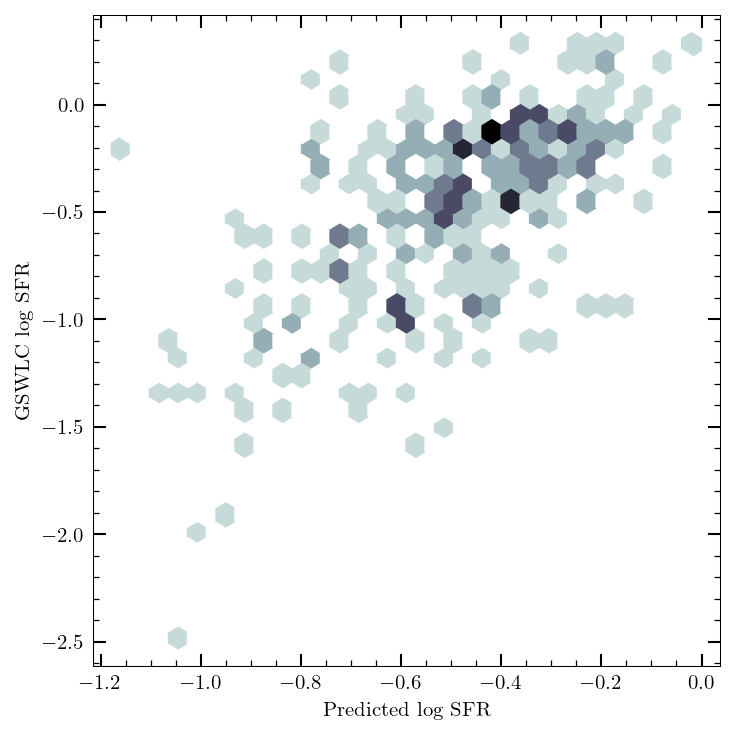

In [104]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:

        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=30)
#plt.plot([-1, 0.1], [-1, .1])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=30, cmap='bone_r')
#plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(#xlim=(-2, 0.5), ylim=(-2, 0.5), 
    xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

[Text(0.5, 0, 'Predicted  log SFR'), Text(0, 0.5, 'GSWLC log SFR')]

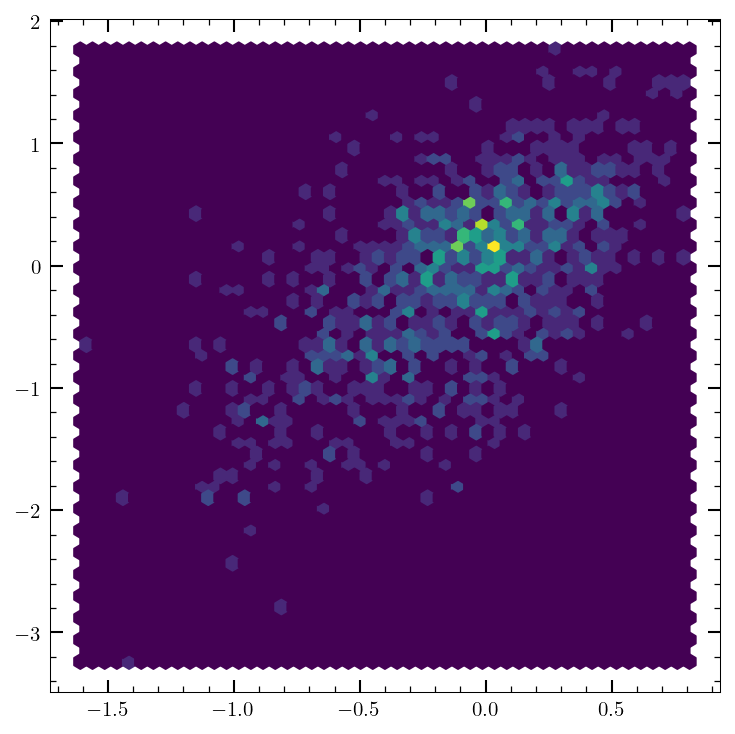

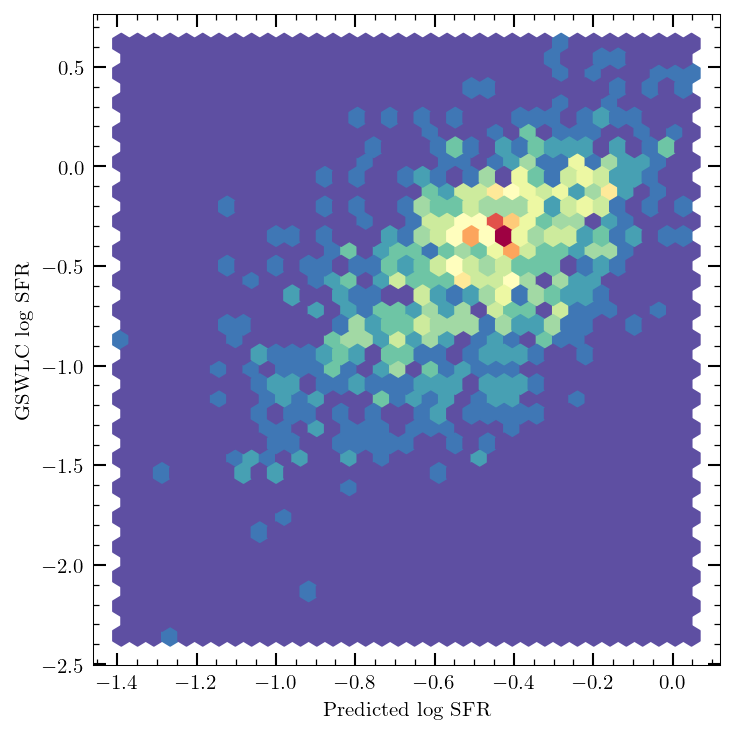

In [79]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in train_loader:

        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=50)
#plt.plot([-1, 0.1], [-1, .1])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
#plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(#xlim=(-2, 0.5), ylim=(-2, 0.5), 
    xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')

[Text(0.5, 0, 'Predicted  log SFR'), Text(0, 0.5, 'GSWLC log SFR')]

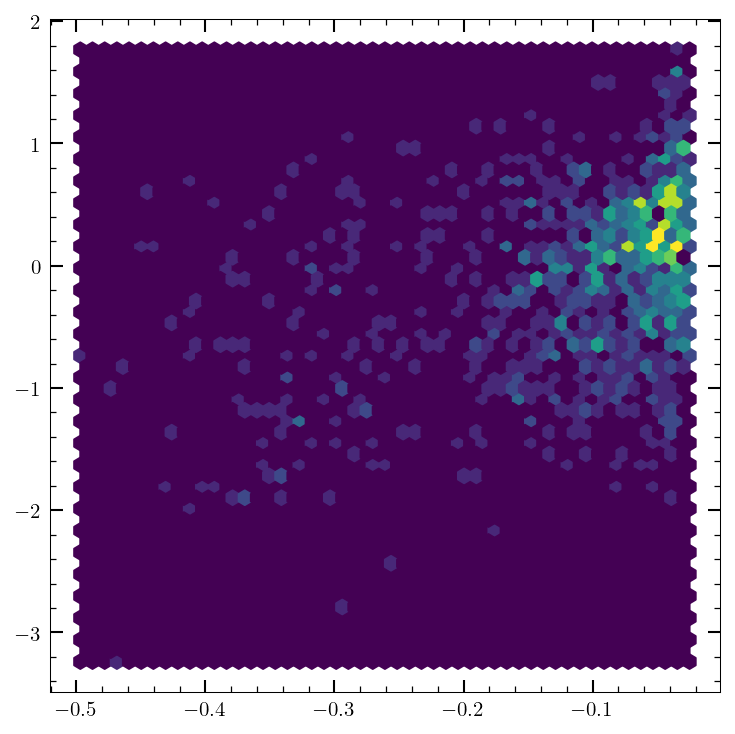

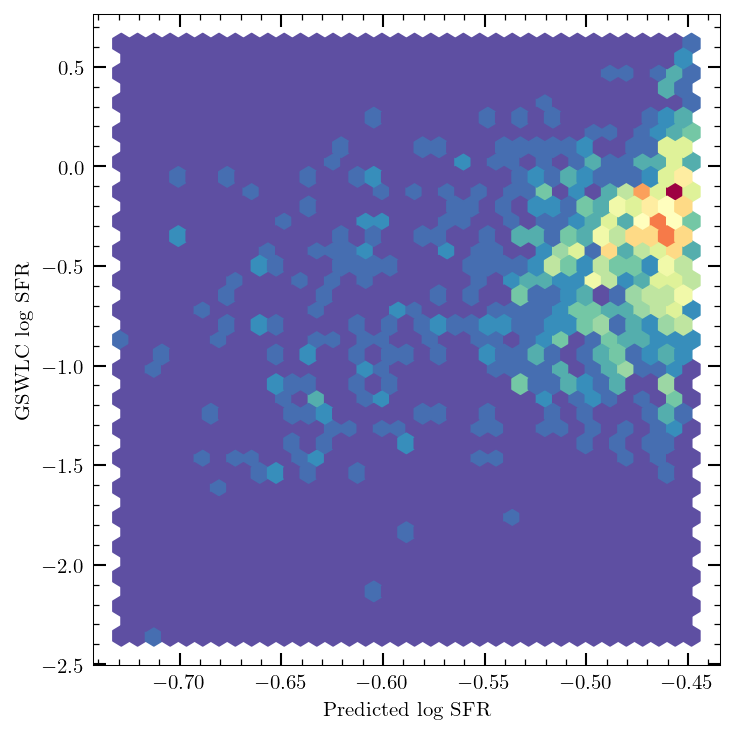

In [110]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in train_loader:

        try:
            model_input = torch.reshape(data, [batch_size, 17])
        except RuntimeError as e:
            continue
        output = model(model_input)
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( output_almanach,
            check_collection, gridsize=50)
#plt.plot([-1, 0.1], [-1, .1])
fig, axes = plt.subplots(figsize=(5,5), dpi=150)
plt.hexbin( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)), gridsize=35, cmap='Spectral_r')
#plt.plot([-1.5, 0.1], [-1.5, .1], c='w')
axes.set(#xlim=(-2, 0.5), ylim=(-2, 0.5), 
    xlabel='Predicted  log SFR', ylabel='GSWLC log SFR')